In [60]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [61]:
experiment       = 'synth1'
#abduction       = False
coeff_estimation = False

# Define the number of samples per environment. Currently every environment has the same number of samples
if experiment == 'synth1' or experiment == 'synth1.1' or experiment == 'synth1.2':
    num_llsamples, num_hlsamples  = params.n_samples['synth1']
if experiment == 'lucas6x3' or experiment == 'lucas6x3.1' or experiment == 'lucas6x3.2':
    num_llsamples, num_hlsamples  = params.n_samples['lucas6x3']

In [38]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
l        = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
h        = len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

In [39]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
# if abduction == True:
#     U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
#     U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
# else:
#     U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
#     U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [ ]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [41]:
# ll_loc = params.loc[experiment][0]
# ll_scale = params.scale[experiment][0]
# hl_loc = params.loc[experiment][1]
# hl_scale = params.scale[experiment][1]
# lenv = ops.MultivariateLaplace(ll_loc, ll_scale) #LIGHT TAILS??????
# henv = ops.MultivariateLaplace(hl_loc, hl_scale)

# U_ll_hat = lenv.sample(num_llsamples)
# U_hl_hat = henv.sample(num_hlsamples)

# Optimisation

### 1. ERiCA optimization


In [ ]:
ll_bound = mut.compute_radius_lb(N=num_llsamples, eta=0.05, c=1000)
hl_bound = mut.compute_radius_lb(N=num_hlsamples, eta=0.05, c=1000)

print(f"LL bound: {ll_bound:.4f}, HL bound: {hl_bound:.4f}")

#needs to change

NameError: name 'mut' is not defined

In [44]:
epsilon, delta = ll_bound, hl_bound

eta_max = 0.001
eta_min = 0.001

max_iter = 500
num_steps_min = 5
num_steps_max = 5

robust_L = True 
robust_H = True

initialization = 'random'

tol  = 1e-4
seed = 23

In [45]:
opt_params_erica = {
                        'U_L': U_ll_hat,
                        'U_H': U_hl_hat,
                        'L_models': LLmodels,
                        'H_models': HLmodels,
                        'omega': omega,
                        'epsilon': epsilon,
                        'delta': delta,
                        'eta_min': eta_min,
                        'eta_max': eta_max,
                        'num_steps_min': num_steps_min,
                        'num_steps_max': num_steps_max,
                        'max_iter': max_iter,
                        'tol': tol,
                        'seed': seed,
                        'robust_L': robust_L,
                        'robust_H': robust_H,
                        'initialization': initialization,
                        'experiment': experiment
                    }

In [ ]:
# Define different epsilon=delta values
eps_delta_values     = [8, ll_bound, 1, 2, 4]
diroca_train_results_empirical = {}

# For each epsilon=delta value
for eps_delta in eps_delta_values:
    print(f"Training for ε=δ = {eps_delta}")
    # Update theta parameters
    opt_params_erica['theta_hatL']['radius'] = eps_delta
    opt_params_erica['theta_hatH']['radius'] = eps_delta
    
    # Run ERICA optimization
    params_empirical, T_empirical = oput.run_empirical_erica_optimization(**opt_params_erica)
    
    # Store results including optimization parameters and transformation matrix
    diroca_train_results_empirical['T_'+str(eps_delta)] = {
                                                    'optimization_params': params_empirical,
                                                    'T_matrix': T_empirical
                                                }

print("\nTraining completed. T matrices stored in trained_results dictionary.")
print("Available ε=δ values:", list(diroca_train_results_empirical.keys()))



In [2]:
# # Define different epsilon=delta values
# eps_delta_values = [1, 2, 4]
# trained_results = {}

# # For each epsilon=delta value
# for eps_delta in eps_delta_values:
#     print(f"Training for ε=δ = {eps_delta}")
#     # Update theta parameters
#     opt_params_erica['epsilon'] = eps_delta
#     opt_params_erica['delta'] = eps_delta
    
#     # Run both ERICA optimizations
#     params_empirical, T_empirical = oput.run_empirical_erica_optimization(**opt_params_erica)
    
#     # Store results including optimization parameters and transformation matrices
#     trained_results[eps_delta] = {'optimization_params': params_empirical, 'T_matrix': T_empirical}

# print("\nTraining completed. Empirical T matrices stored in trained_results dictionary.")
# print("Available ε=δ values:", list(trained_results.keys()))

### 2. ENRiCO optimization

In [47]:
params_enrico, T_enrico = oput.run_empirical_erica_optimization(**{**opt_params_erica, 'robust_L': False, 'robust_H': False})

100%|██████████| 500/500 [00:31<00:00, 16.10it/s]


In [ ]:
diroca_train_results_empirical['T_0.00'] = {
                                'optimization_params': params_enrico,
                                'T_matrix': T_enrico
                            }

## 4. Randomized Smoothing

In [49]:
opt_params_smooth = {
                        'U_L': U_ll_hat,
                        'U_H': U_hl_hat,
                        'L_models': LLmodels,
                        'H_models': HLmodels,
                        'omega': omega,
                        'eta_min': eta_min,
                        'num_steps_min': num_steps_min,
                        'max_iter': max_iter,
                        'tol': tol,
                        'seed': seed,
                        'noise_sigma': 0.1,
                        'num_noise_samples': 10
                        }

In [50]:
params_smooth, T_smooth = oput.run_empirical_smooth_optimization(**opt_params_smooth)

 84%|████████▍ | 420/500 [09:50<01:52,  1.41s/it]

Converged at iteration 421


In [ ]:
diroca_train_results_empirical['T_s'] = {
                                'optimization_params': params_smooth,
                                'T_matrix': T_smooth
                            }

## Save the results

In [51]:
joblib.dump(diroca_train_results, f"data/{experiment}/diroca_train_results.pkl")

['data/lucas6x3/Tau.pkl']

# Evaluation

In [52]:
# methods = {
#             'T_erica': T_erica, 'T_enrico': T_enrico,
#             'T_random': T_random, 'T_random2': T_random2,
#             'T_smooth': T_smooth, 'Tau': Tau
#           }
methods = {
            'T00': T_enrico, 'Ts': T_smooth
          }


data           = mut.load_samples(experiment)

# Load data
#data = mut.load_samples(experiment)

# Generate data
data = evut.generate_empirical_data(LLmodels, HLmodels, omega, U_ll_hat, U_hl_hat)

### Abstraction error comparison

In [53]:
add_pertL          = True
add_pertH          = True
pert_typeL         = 'random_normal'
pert_typeH         = 'random_normal'

test_observ        = True
test_interv        = True 

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'huber'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'fro'
num_iter           = 20

In [54]:
if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

In [55]:
def load_empirical_optimization_params(experiment, level, method='erica'):
    save_dir = f"data/{experiment}/{method}"
    try:
        opt_params = joblib.load(f"{save_dir}/opt_params.pkl")
        params_L, params_H = opt_params['L'], opt_params['H']

        return {'L': params_L, 'H': params_H}[level]
       
    except FileNotFoundError:
        print(f"No saved parameters found in {save_dir}/opt_params.pkl")
        return None, None

In [56]:
def sample_from_frobenius_ball(params, radius_type, boundary, rand_rad):
    """
    Initialize a matrix inside the Frobenius ball with ||X||_F^2 <= N*epsilon^2
    """
    num_samples, num_vars = params['pert_U'].shape
    if radius_type == 'worst_case':
        radius = params['radius_worst']

    elif radius_type == 'hat_case':
        radius = params['radius']

    elif radius_type == 'random':
        radius = rand_rad
        
    matrix           = np.random.randn(num_samples, num_vars)  
    squared_norm     = np.linalg.norm(matrix, 'fro')**2
    max_squared_norm = num_samples * radius**2
    
    if boundary == True:
        scaling_factor = np.sqrt(max_squared_norm / squared_norm) * np.random.rand(1)
    else:
        scaling_factor = np.sqrt(max_squared_norm / squared_norm)
    return matrix * scaling_factor

In [57]:
def generate_pertubation(pert_type, pert_level, experiment, rad=None):
    
    params = load_empirical_optimization_params(experiment, pert_level)
    
    if pert_type == 'sample_radius':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=False, rand_rad=rad)
    
    elif pert_type == 'sample_radius_worst':
        P = sample_from_frobenius_ball(params, 'worst_case', boundary=False, rand_rad=rad)

    elif pert_type == 'boundary_worst':
        P = params['pert_U']
        
    elif pert_type == 'boundary_hat':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=True, rand_rad=rad)

    elif pert_type == 'random_hat':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=False, rand_rad=rad)

    elif pert_type == 'random_worst':
        P = sample_from_frobenius_ball(params, 'worst_case', boundary=False, rand_rad=rad)

    elif pert_type == 'boundary_random_hat':
        P = sample_from_frobenius_ball(params, 'hat_case', boundary=True, rand_rad=rad)

    elif pert_type == 'boundary_random_worst':
        P = sample_from_frobenius_ball(params, 'worst_case', boundary=True, rand_rad=rad)

    elif pert_type == 'random_normal':
        P = np.random.randn(*params['pert_U'].shape)

    return P

In [58]:
rad_values = [1,2,4,8]

In [59]:

for eps_delta in eps_delta_values:
    method_name = f'T_{eps_delta:.2f}'  # e.g., 'T_0.05', 'T_1.00', etc.
    methods[method_name] = trained_results[eps_delta]['T_matrix']


# Now run the evaluation with all methods
abstraction_error = {name: [] for name in methods.keys()}
for rad in rad_values:
    for iter_num in tqdm(range(num_iter)):
        pert_L = generate_pertubation('sample_radius_worst', 'L', experiment, rad)
        pert_H = generate_pertubation('sample_radius_worst', 'H', experiment, rad)

        for name, T in methods.items():

            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]

                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                if lin_contaminationL:
                    base  = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                if lin_contaminationH:
                    abst  = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')
                # Apply method and compute distance
                tau_base = base @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                total   += dist
                
            iter_avg = total / len(Ill)
            abstraction_error[name].append(iter_avg)

    final_abstraction_error = {}
    for method in methods:
        mean_e = np.mean(abstraction_error[method])
        std_e  = np.std(abstraction_error[method])
        final_abstraction_error[method] = (mean_e, std_e)

    print(f"\nResults for radius {rad}:")
    for method, (mean, std) in final_abstraction_error.items():
        print(f"{method}: {mean:.4f} ± {1.96*std:.4f}")

100%|██████████| 20/20 [00:05<00:00,  3.68it/s]



Results for radius 1:
T00: 2988.4291 ± 5.6246
Ts: 2482.2170 ± 5.3557
T_1.00: 2090.3666 ± 4.6140
T_2.00: 1816.3346 ± 4.1765
T_4.00: 1793.2006 ± 4.1182


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]



Results for radius 2:
T00: 2987.6353 ± 5.6731
Ts: 2482.4168 ± 5.3004
T_1.00: 2090.1434 ± 4.0757
T_2.00: 1816.2774 ± 3.7102
T_4.00: 1793.1214 ± 3.6764


100%|██████████| 20/20 [00:04<00:00,  4.20it/s]



Results for radius 4:
T00: 2987.1902 ± 6.0025
Ts: 2482.0332 ± 5.9766
T_1.00: 2089.7562 ± 4.3992
T_2.00: 1815.9833 ± 3.7496
T_4.00: 1792.8407 ± 3.6914


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Results for radius 8:
T00: 2987.3365 ± 5.8853
Ts: 2482.1647 ± 5.7937
T_1.00: 2089.7837 ± 4.2231
T_2.00: 1815.9937 ± 3.5769
T_4.00: 1792.8464 ± 3.4690


In [25]:
pert_types = ['sample_radius', 'sample_radius_worst', 'boundary_worst', 'boundary_hat',
              'random_hat', 'random_worst', 'boundary_random_hat', 'boundary_random_worst', 'random_normal']

sample_radius


100%|██████████| 20/20 [00:01<00:00, 19.13it/s]


Average e(τ) for Ted: 1788.096 ± 1.846

Average e(τ) for T00: 1904.682 ± 2.000

Average e(τ) for Ts: 2077.572 ± 3.202



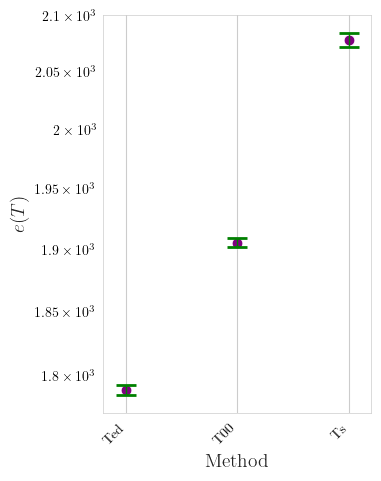


sample_radius_worst


100%|██████████| 20/20 [00:00<00:00, 20.97it/s]


Average e(τ) for Ted: 1779.161 ± 2.027

Average e(τ) for T00: 1852.146 ± 2.259

Average e(τ) for Ts: 1876.260 ± 2.116



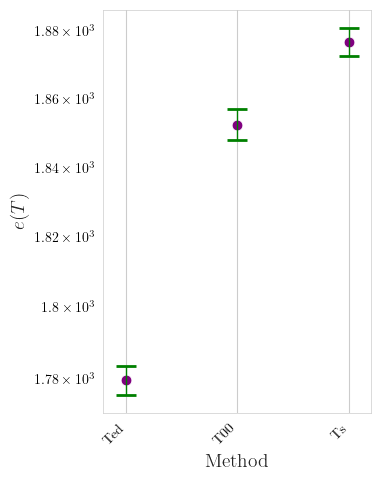


boundary_worst


100%|██████████| 20/20 [00:00<00:00, 36.45it/s]


Average e(τ) for Ted: 2337.253 ± 0.000

Average e(τ) for T00: 2363.622 ± 0.000

Average e(τ) for Ts: 2812.985 ± 0.000



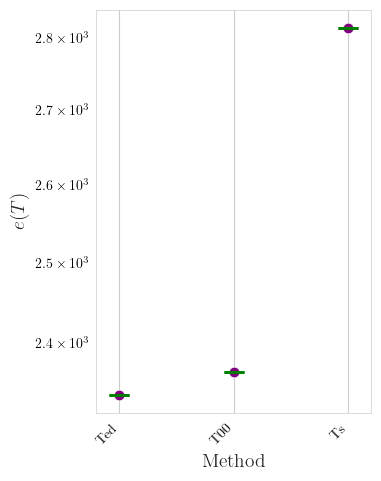


boundary_hat


100%|██████████| 20/20 [00:00<00:00, 22.65it/s]


Average e(τ) for Ted: 1428.680 ± 178.383

Average e(τ) for T00: 1480.999 ± 174.898

Average e(τ) for Ts: 1358.928 ± 261.331



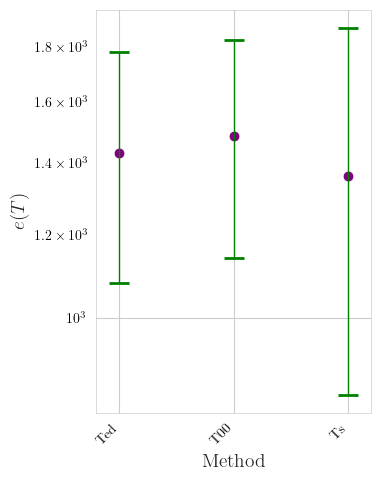


random_hat


100%|██████████| 20/20 [00:00<00:00, 21.07it/s]


Average e(τ) for Ted: 1786.827 ± 1.815

Average e(τ) for T00: 1903.633 ± 2.180

Average e(τ) for Ts: 2078.471 ± 3.603



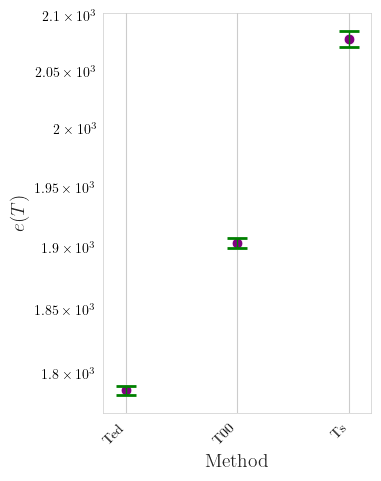


random_worst


100%|██████████| 20/20 [00:00<00:00, 23.38it/s]


Average e(τ) for Ted: 1779.212 ± 1.781

Average e(τ) for T00: 1851.771 ± 2.181

Average e(τ) for Ts: 1876.841 ± 2.437



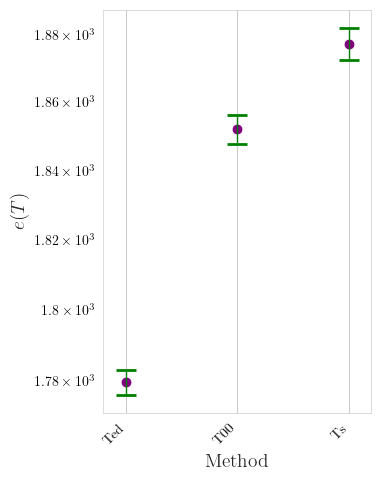


boundary_random_hat


100%|██████████| 20/20 [00:00<00:00, 23.57it/s]


Average e(τ) for Ted: 1408.184 ± 145.849

Average e(τ) for T00: 1460.050 ± 154.382

Average e(τ) for Ts: 1324.591 ± 290.832



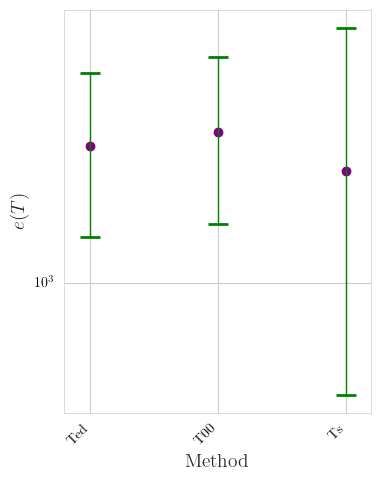


boundary_random_worst


100%|██████████| 20/20 [00:00<00:00, 23.72it/s]


Average e(τ) for Ted: 1334.927 ± 75.958

Average e(τ) for T00: 1379.786 ± 82.381

Average e(τ) for Ts: 1205.217 ± 202.975



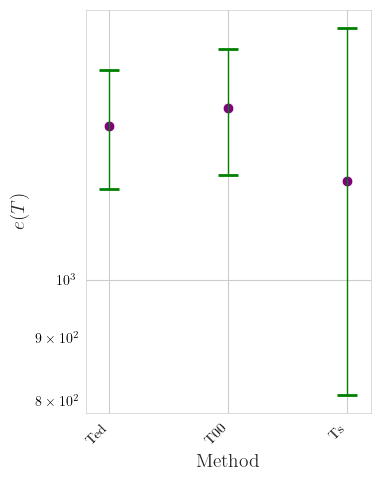


random_normal


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


Average e(τ) for Ted: 1316.665 ± 0.906

Average e(τ) for T00: 1350.555 ± 0.962

Average e(τ) for Ts: 1132.650 ± 1.718



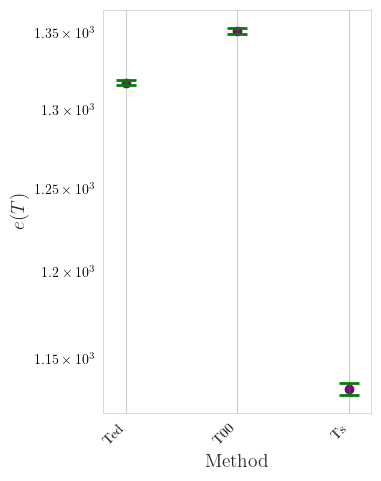

In [26]:
for pert_type in pert_types:
    print(pert_type)
    abstraction_error = {name: [] for name in methods.keys()}

    for iter_num in tqdm(range(num_iter)): 

        pert_L = generate_pertubation(pert_type, 'L', experiment, rad=4)
        pert_H = generate_pertubation(pert_type, 'H', experiment, rad=3)

        for name, T in methods.items():

            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]

                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                if lin_contaminationL:
                    base  = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                if lin_contaminationH:
                    abst  = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')
                # Apply method and compute distance
                tau_base = base @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                total   += dist
                
            iter_avg = total / len(Ill)
            abstraction_error[name].append(iter_avg)
        
        final_abstraction_error = {}
    for name in methods:
        mean_e = np.mean(abstraction_error[name])
        std_e = np.std(abstraction_error[name])
        final_abstraction_error[name] = (mean_e, std_e * 1.96)
        print(f"Average e(τ) for {name}: {mean_e:.3f} ± {std_e:.3f}\n")

    evut.plot_abstraction_error(final_abstraction_error)
    print( )

In [ ]:
print('done!')

In [27]:
# for pert_type in pert_types:
#     pert_typeL = pert_type
#     pert_typeH = pert_type
#     # Define the grid of radii to test
#     radius_values = np.arange(1.5, 14.5, 5).tolist()

#     # Initialize dictionary to store results
#     method_results = {
#                         'ERiCA': {'T': T_erica, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))},
#                         'ENRiCO': {'T': T_enrico, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))},
#                         'Smooth': {'T': T_smooth, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))},
#                         'Tau': {'T': Tau, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))}
#                     }
    
#     # method_results = {
#     #     'ERiCA': {'T': T_erica, 'errors': np.zeros(len(radius_values)), 'stds': np.zeros(len(radius_values))}}

#     # Test each radius
#     for i, radius in enumerate(tqdm(radius_values)):
#         # Dictionary to store errors for current radius
#         current_errors = {method: [] for method in method_results.keys()}
        
#         for _ in range(num_iter):
#             # Generate noise once per iteration
#             pert_L = generate_pertubation(pert_typeL, 'L', experiment, rad=radius)
#             pert_H = generate_pertubation(pert_typeH, 'H', experiment, rad=radius)

#             for method_name, method_info in method_results.items():
#                 total = 0
#                 for iota in test_data.keys():
        
#                     base, abst = test_data[iota]

#                     if add_pertL:
#                         base = base + pert_L 
#                     if add_pertH:
#                         abst = abst + pert_H 
                        
#                     base_norm = base / np.linalg.norm(base, 'fro')
#                     abst_norm = abst / np.linalg.norm(abst, 'fro')

#                     tau_base = base @ method_info['T'].T
#                     dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
#                     total   += dist
            
#                 iter_avg = total / len(Ill)
#                 current_errors[method_name].append(iter_avg)

#         # Store mean and std for all methods
#         for method_name in method_results:
#             method_results[method_name]['errors'][i] = np.mean(current_errors[method_name])
#             method_results[method_name]['stds'][i] = np.std(current_errors[method_name])

#     # Create plot
#     plt.figure(figsize=(12, 8))

#     colors = {'ERiCA': 'blue', 'ENRiCO': 'red', 'Smooth': 'green', 'Tau': 'purple'}
#     for method_name, method_info in method_results.items():
#         plt.plot(radius_values, method_info['errors'], 'o', 
#                 color=colors[method_name], 
#                 label=method_name, 
#                 alpha=0.5, 
#                 markersize=8) 

#     plt.xlabel(r'Radius ($\varepsilon=\delta$)')
#     plt.ylabel('Abstraction Error')
#     plt.title(f'Abstraction Error vs Radius Value for {pert_type}')
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()

#     # Print best radius for all methods
#     for method_name, method_info in method_results.items():
#         best_idx = np.argmin(method_info['errors'])
#         print(f"\nBest radius value for {method_name}:")
#         print(f"Radius (ε=δ): {radius_values[best_idx]}")
#         print(f"Mean error: {method_info['errors'][best_idx]:.4f} ± {method_info['stds'][best_idx]*1.96:.4f}")
#     print( )

100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


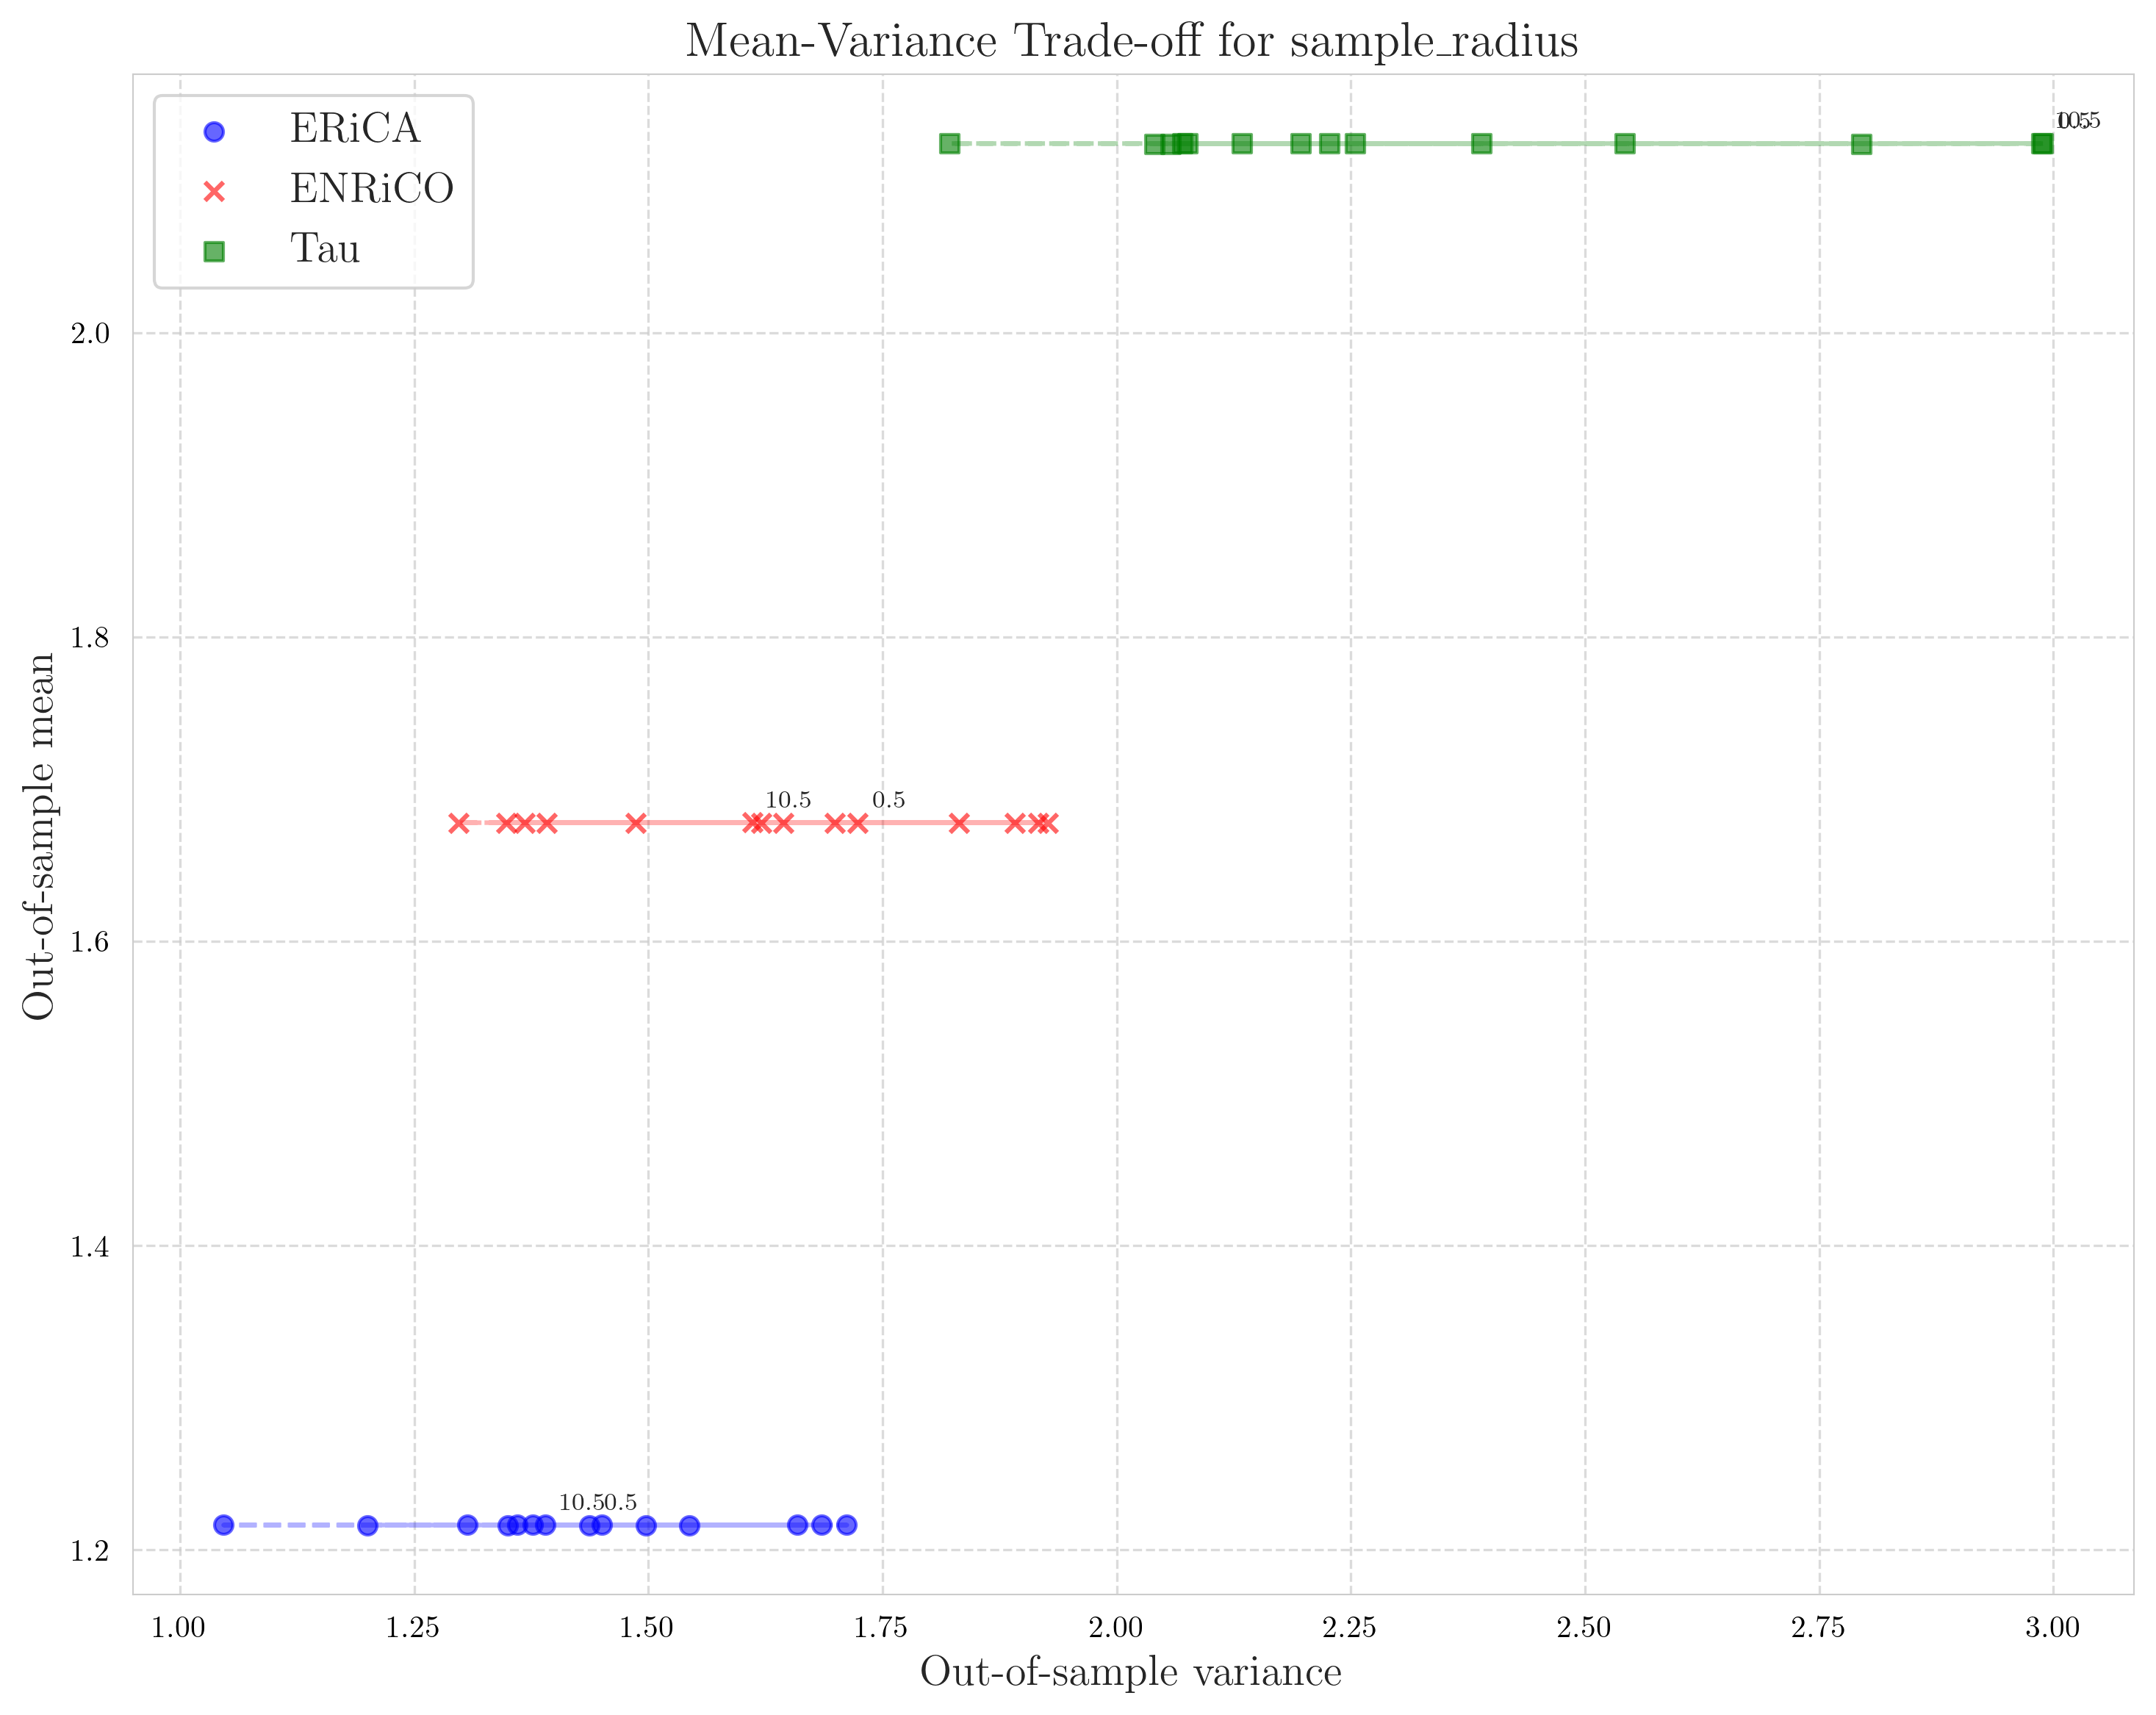

100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


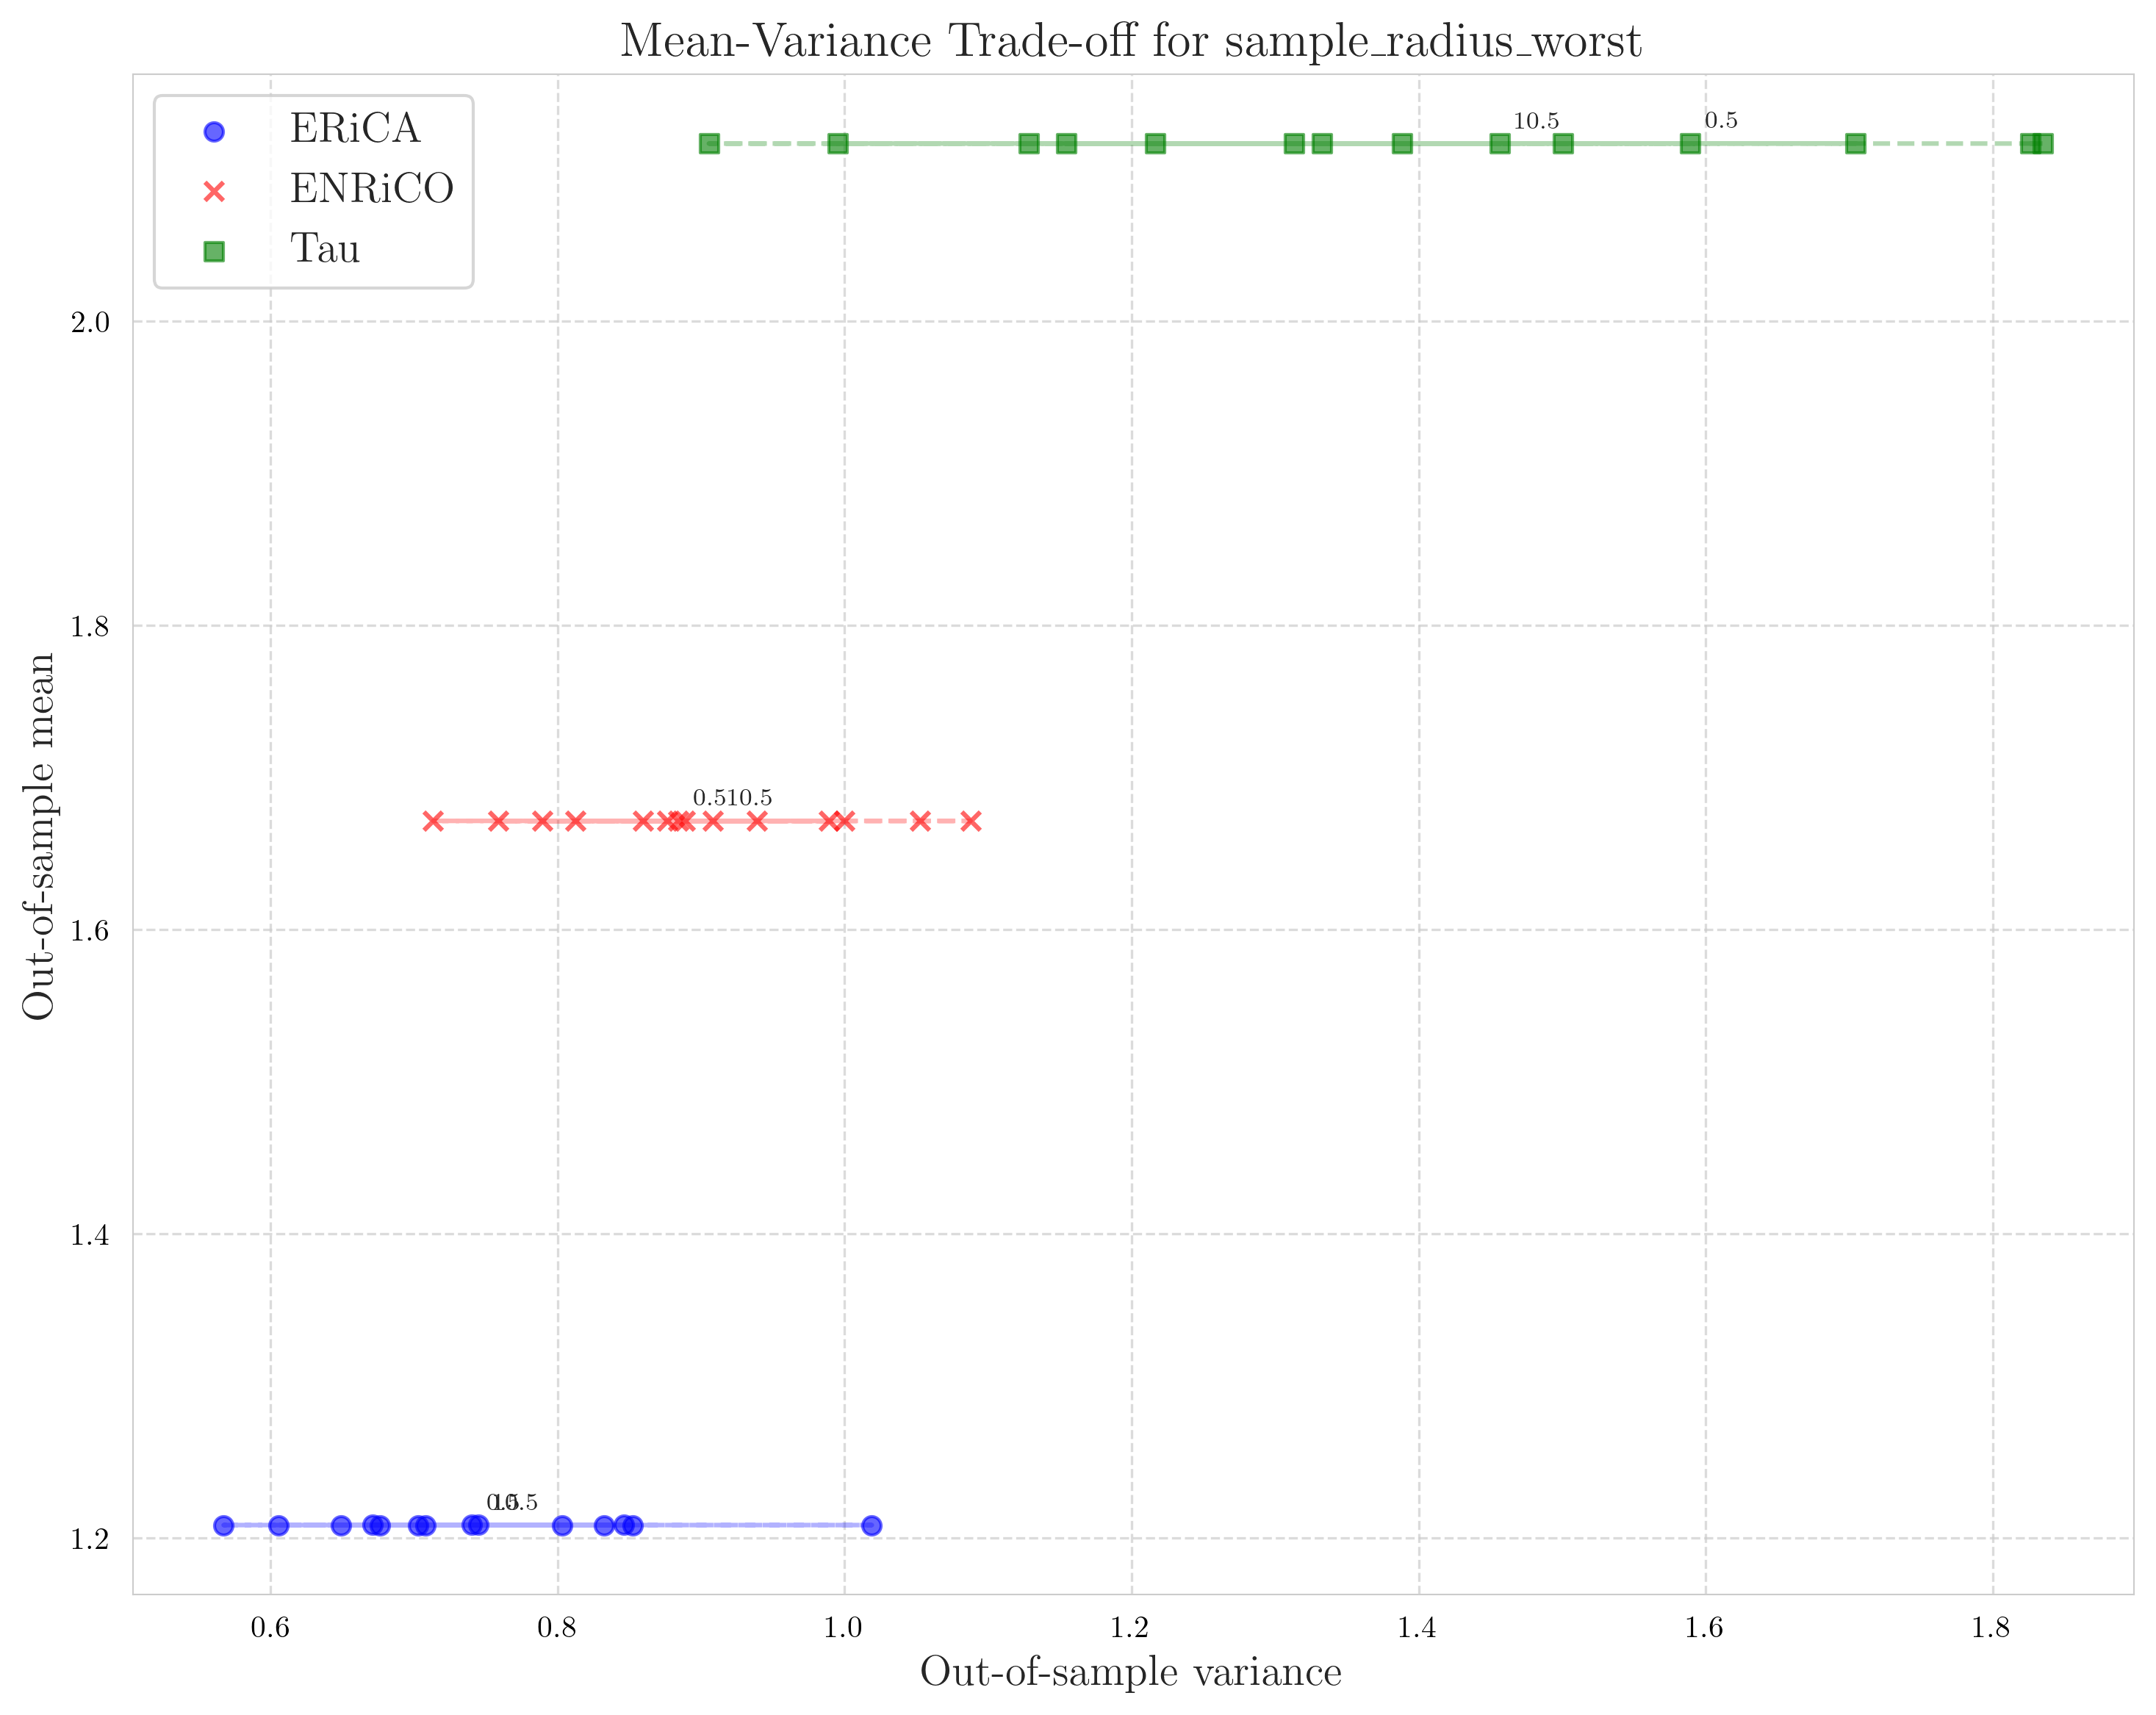

100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


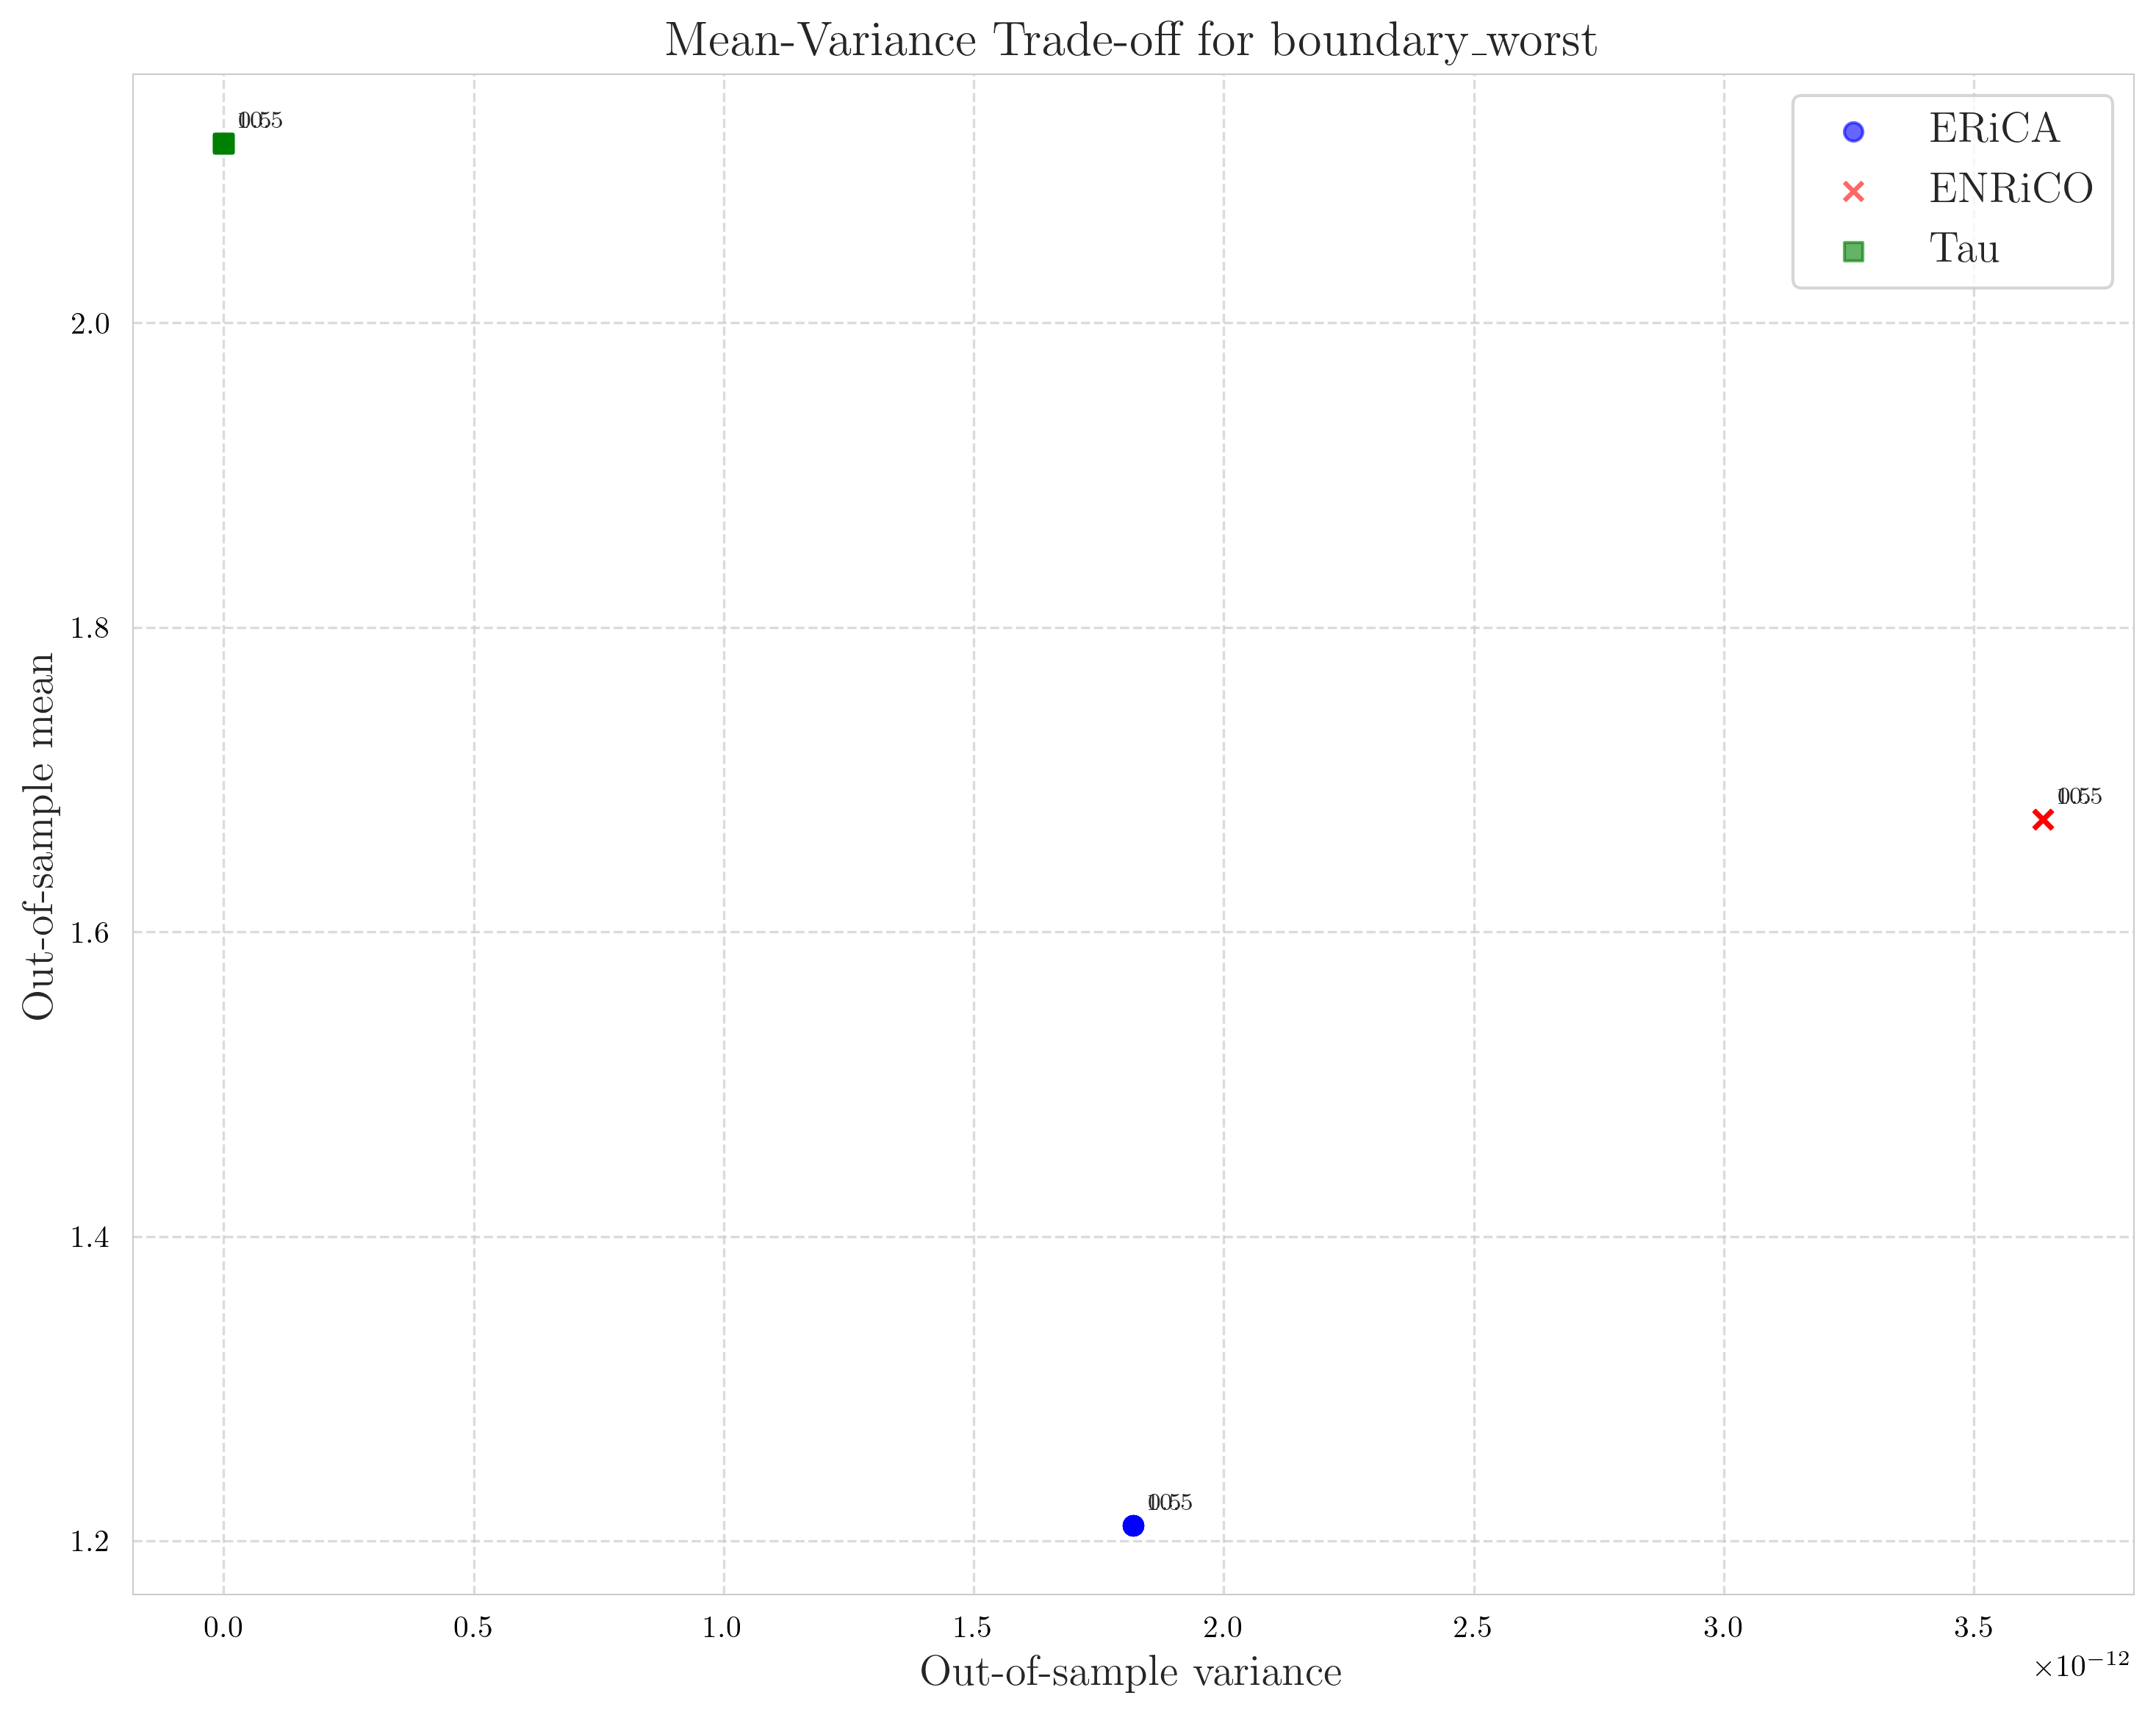

100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


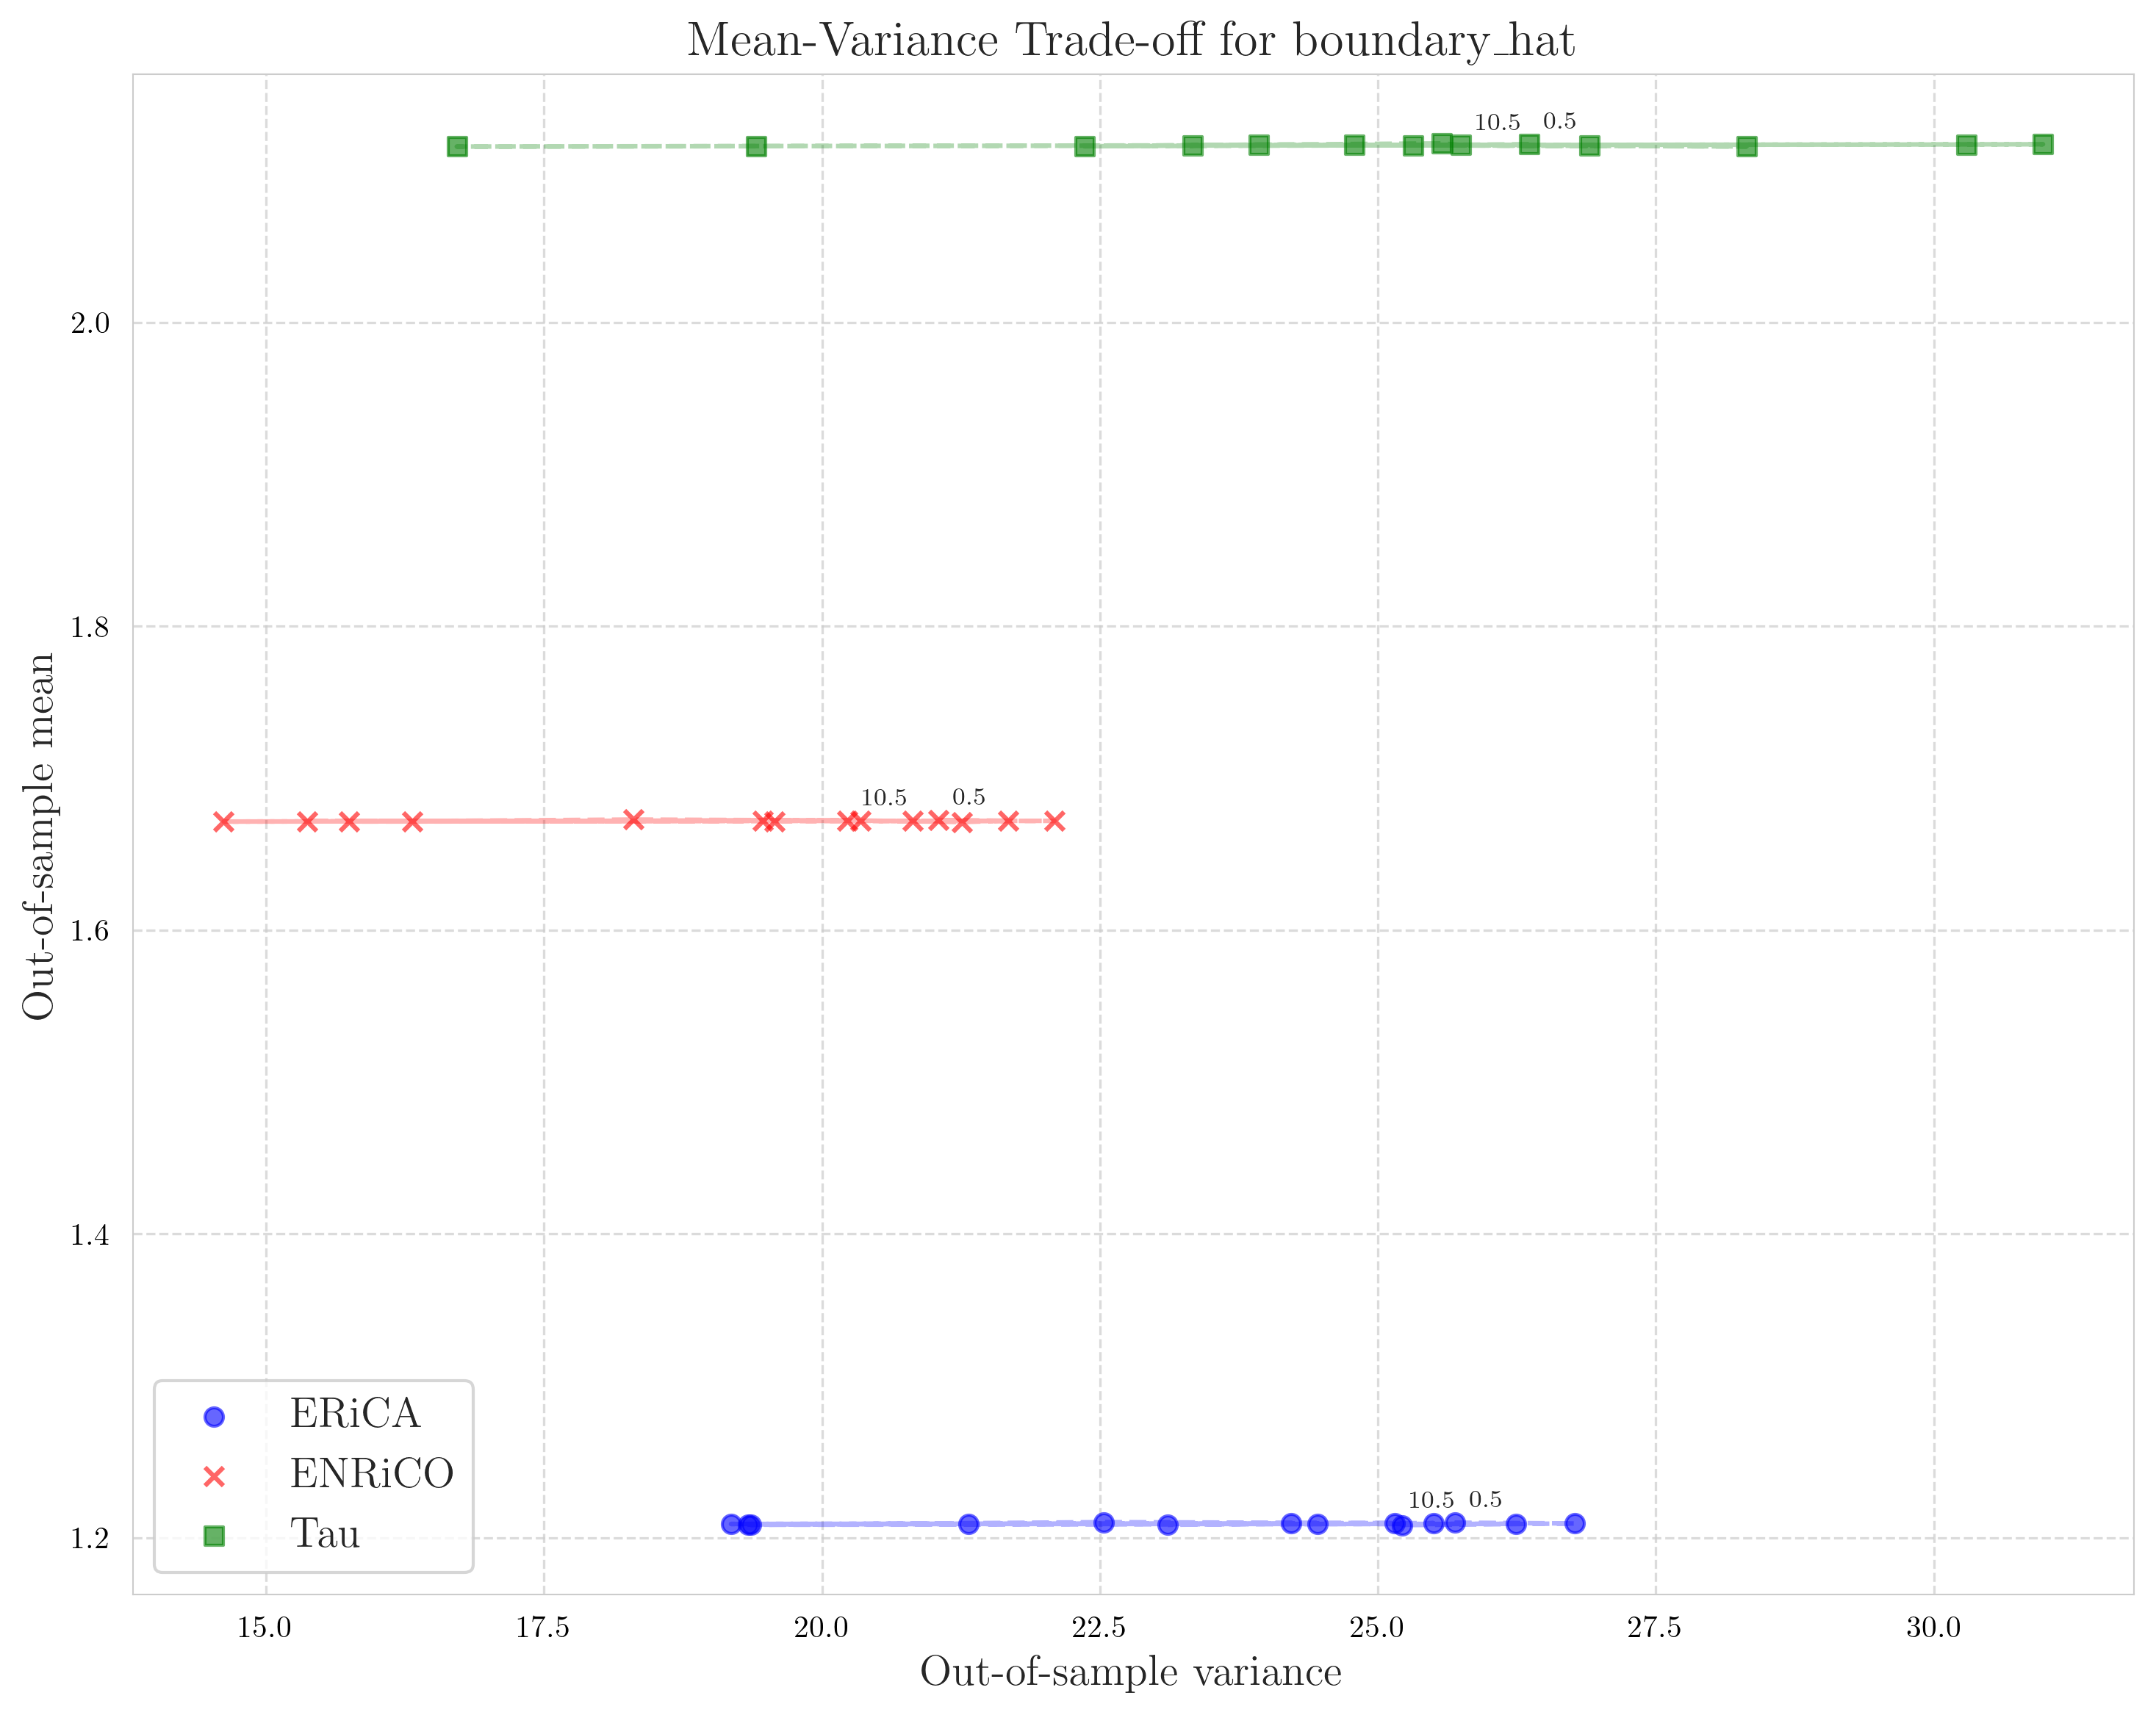

100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


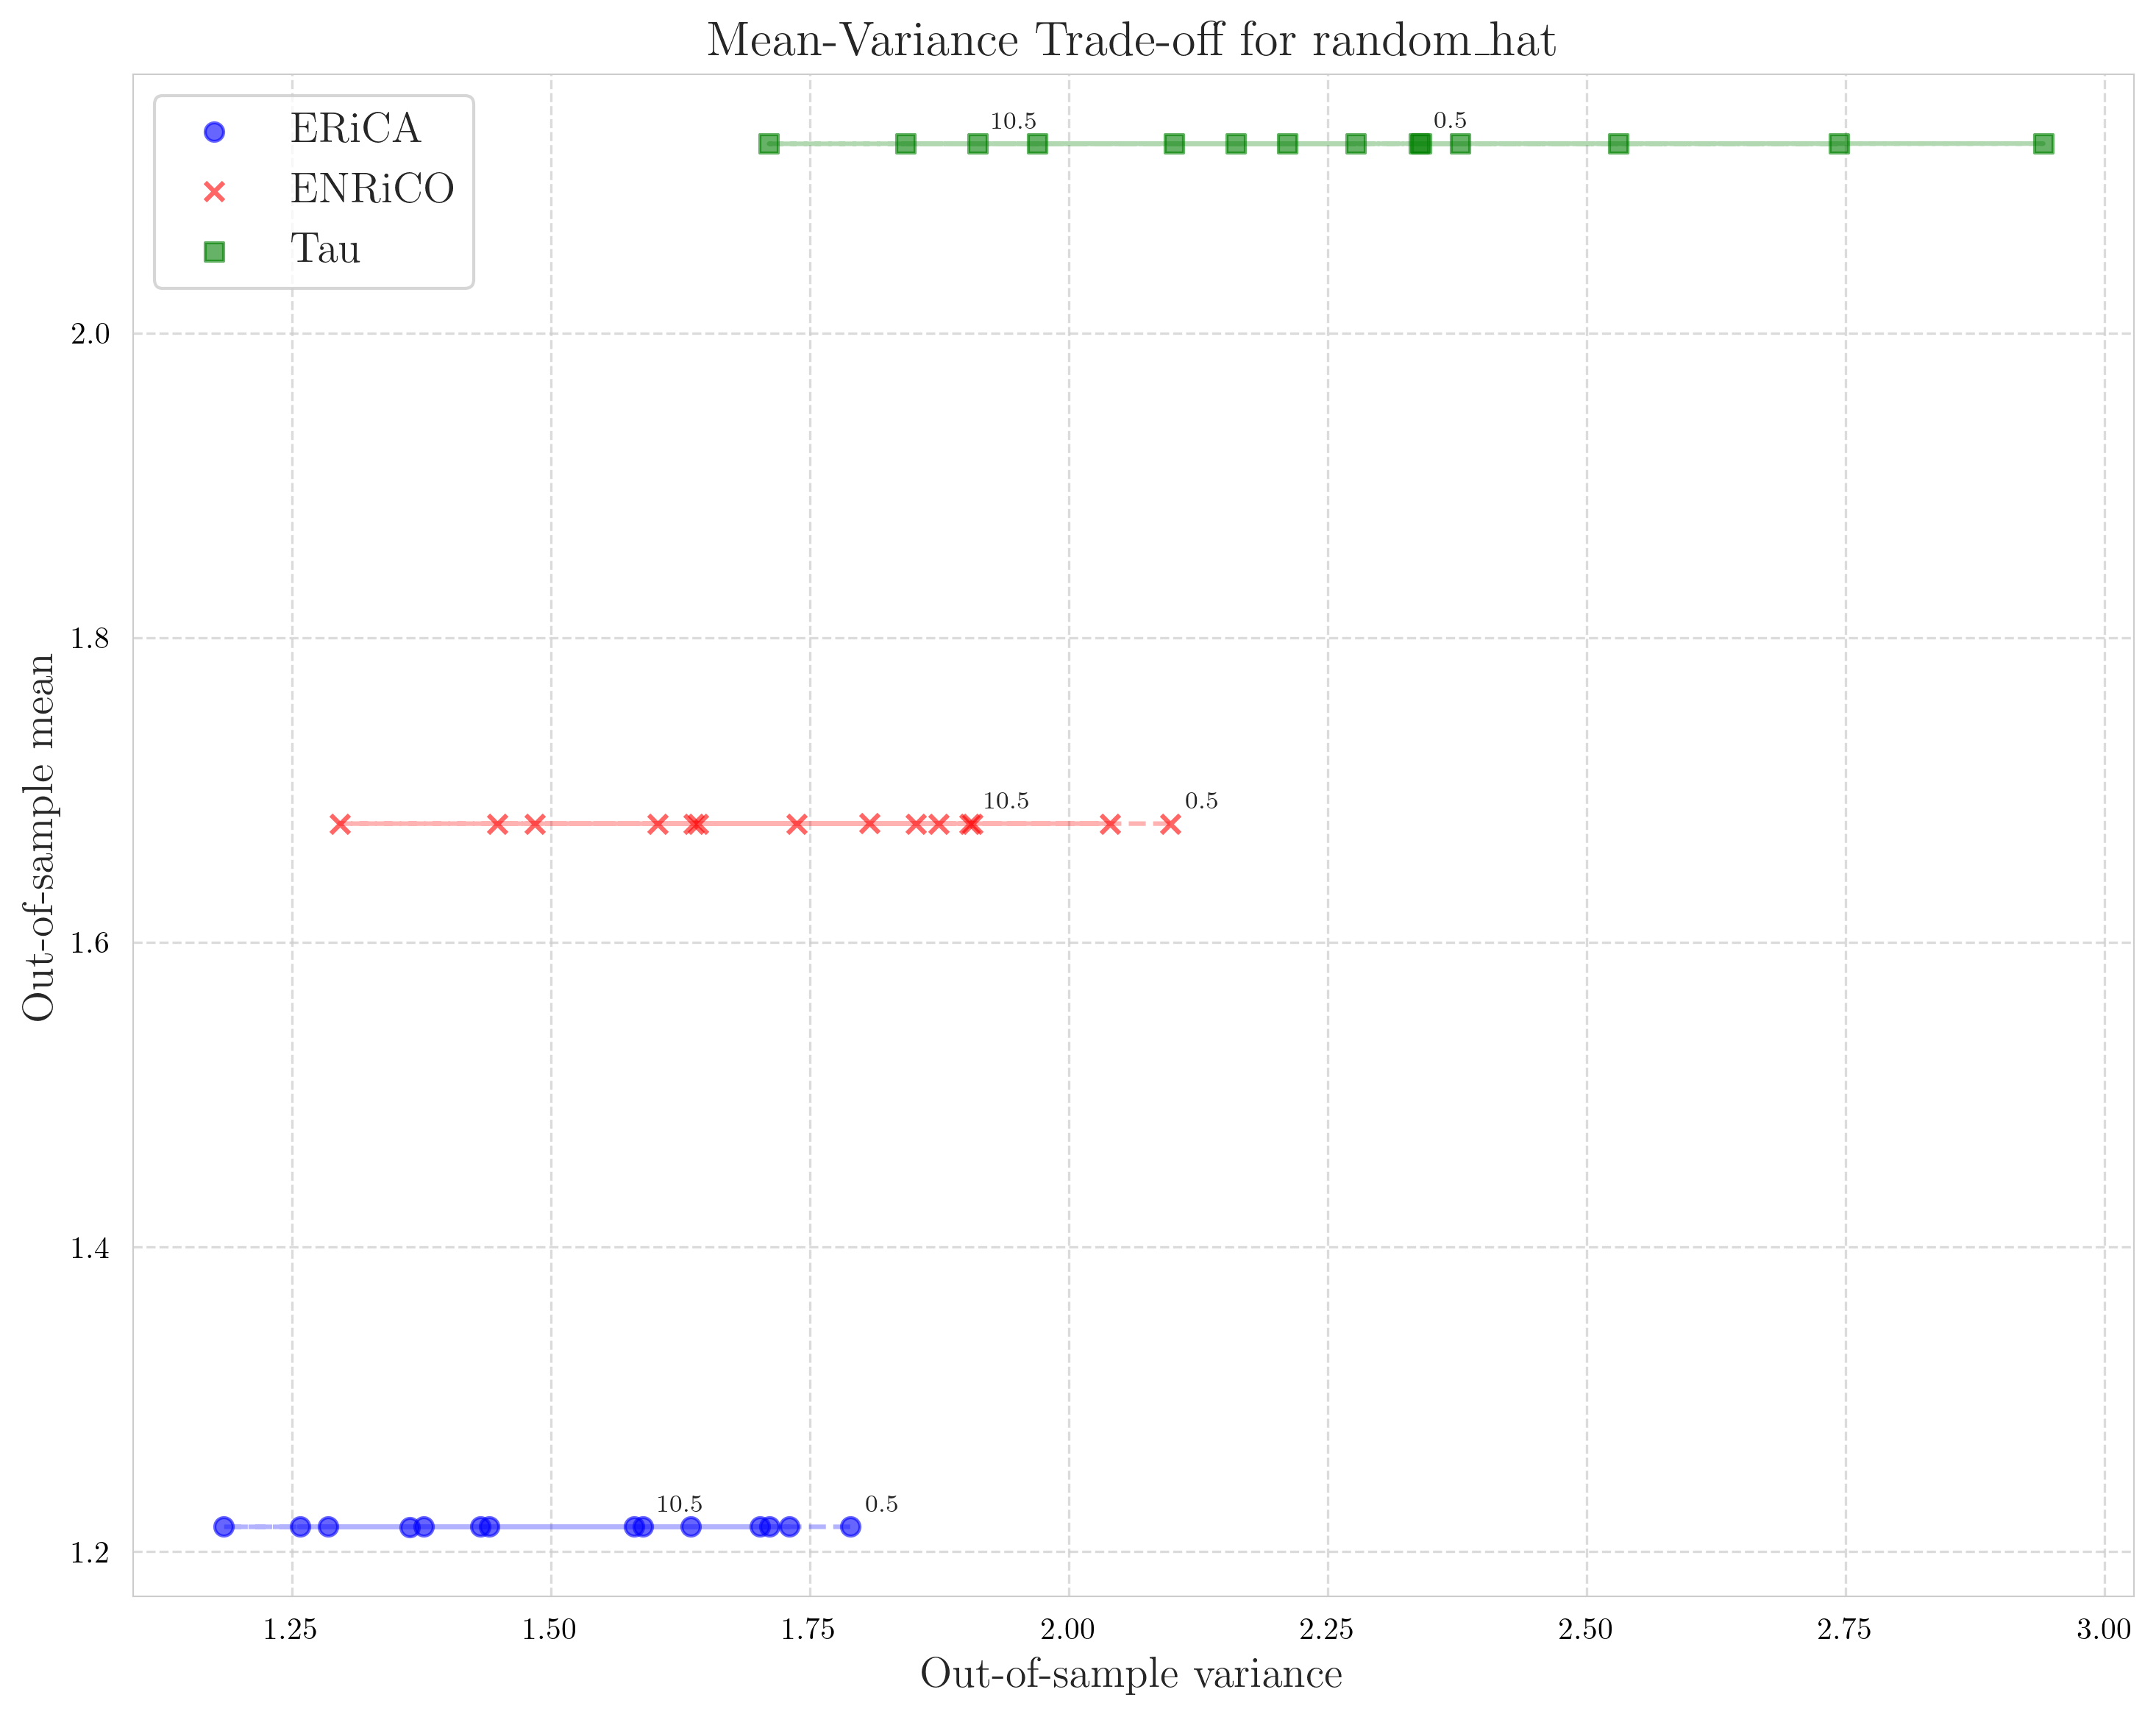

100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


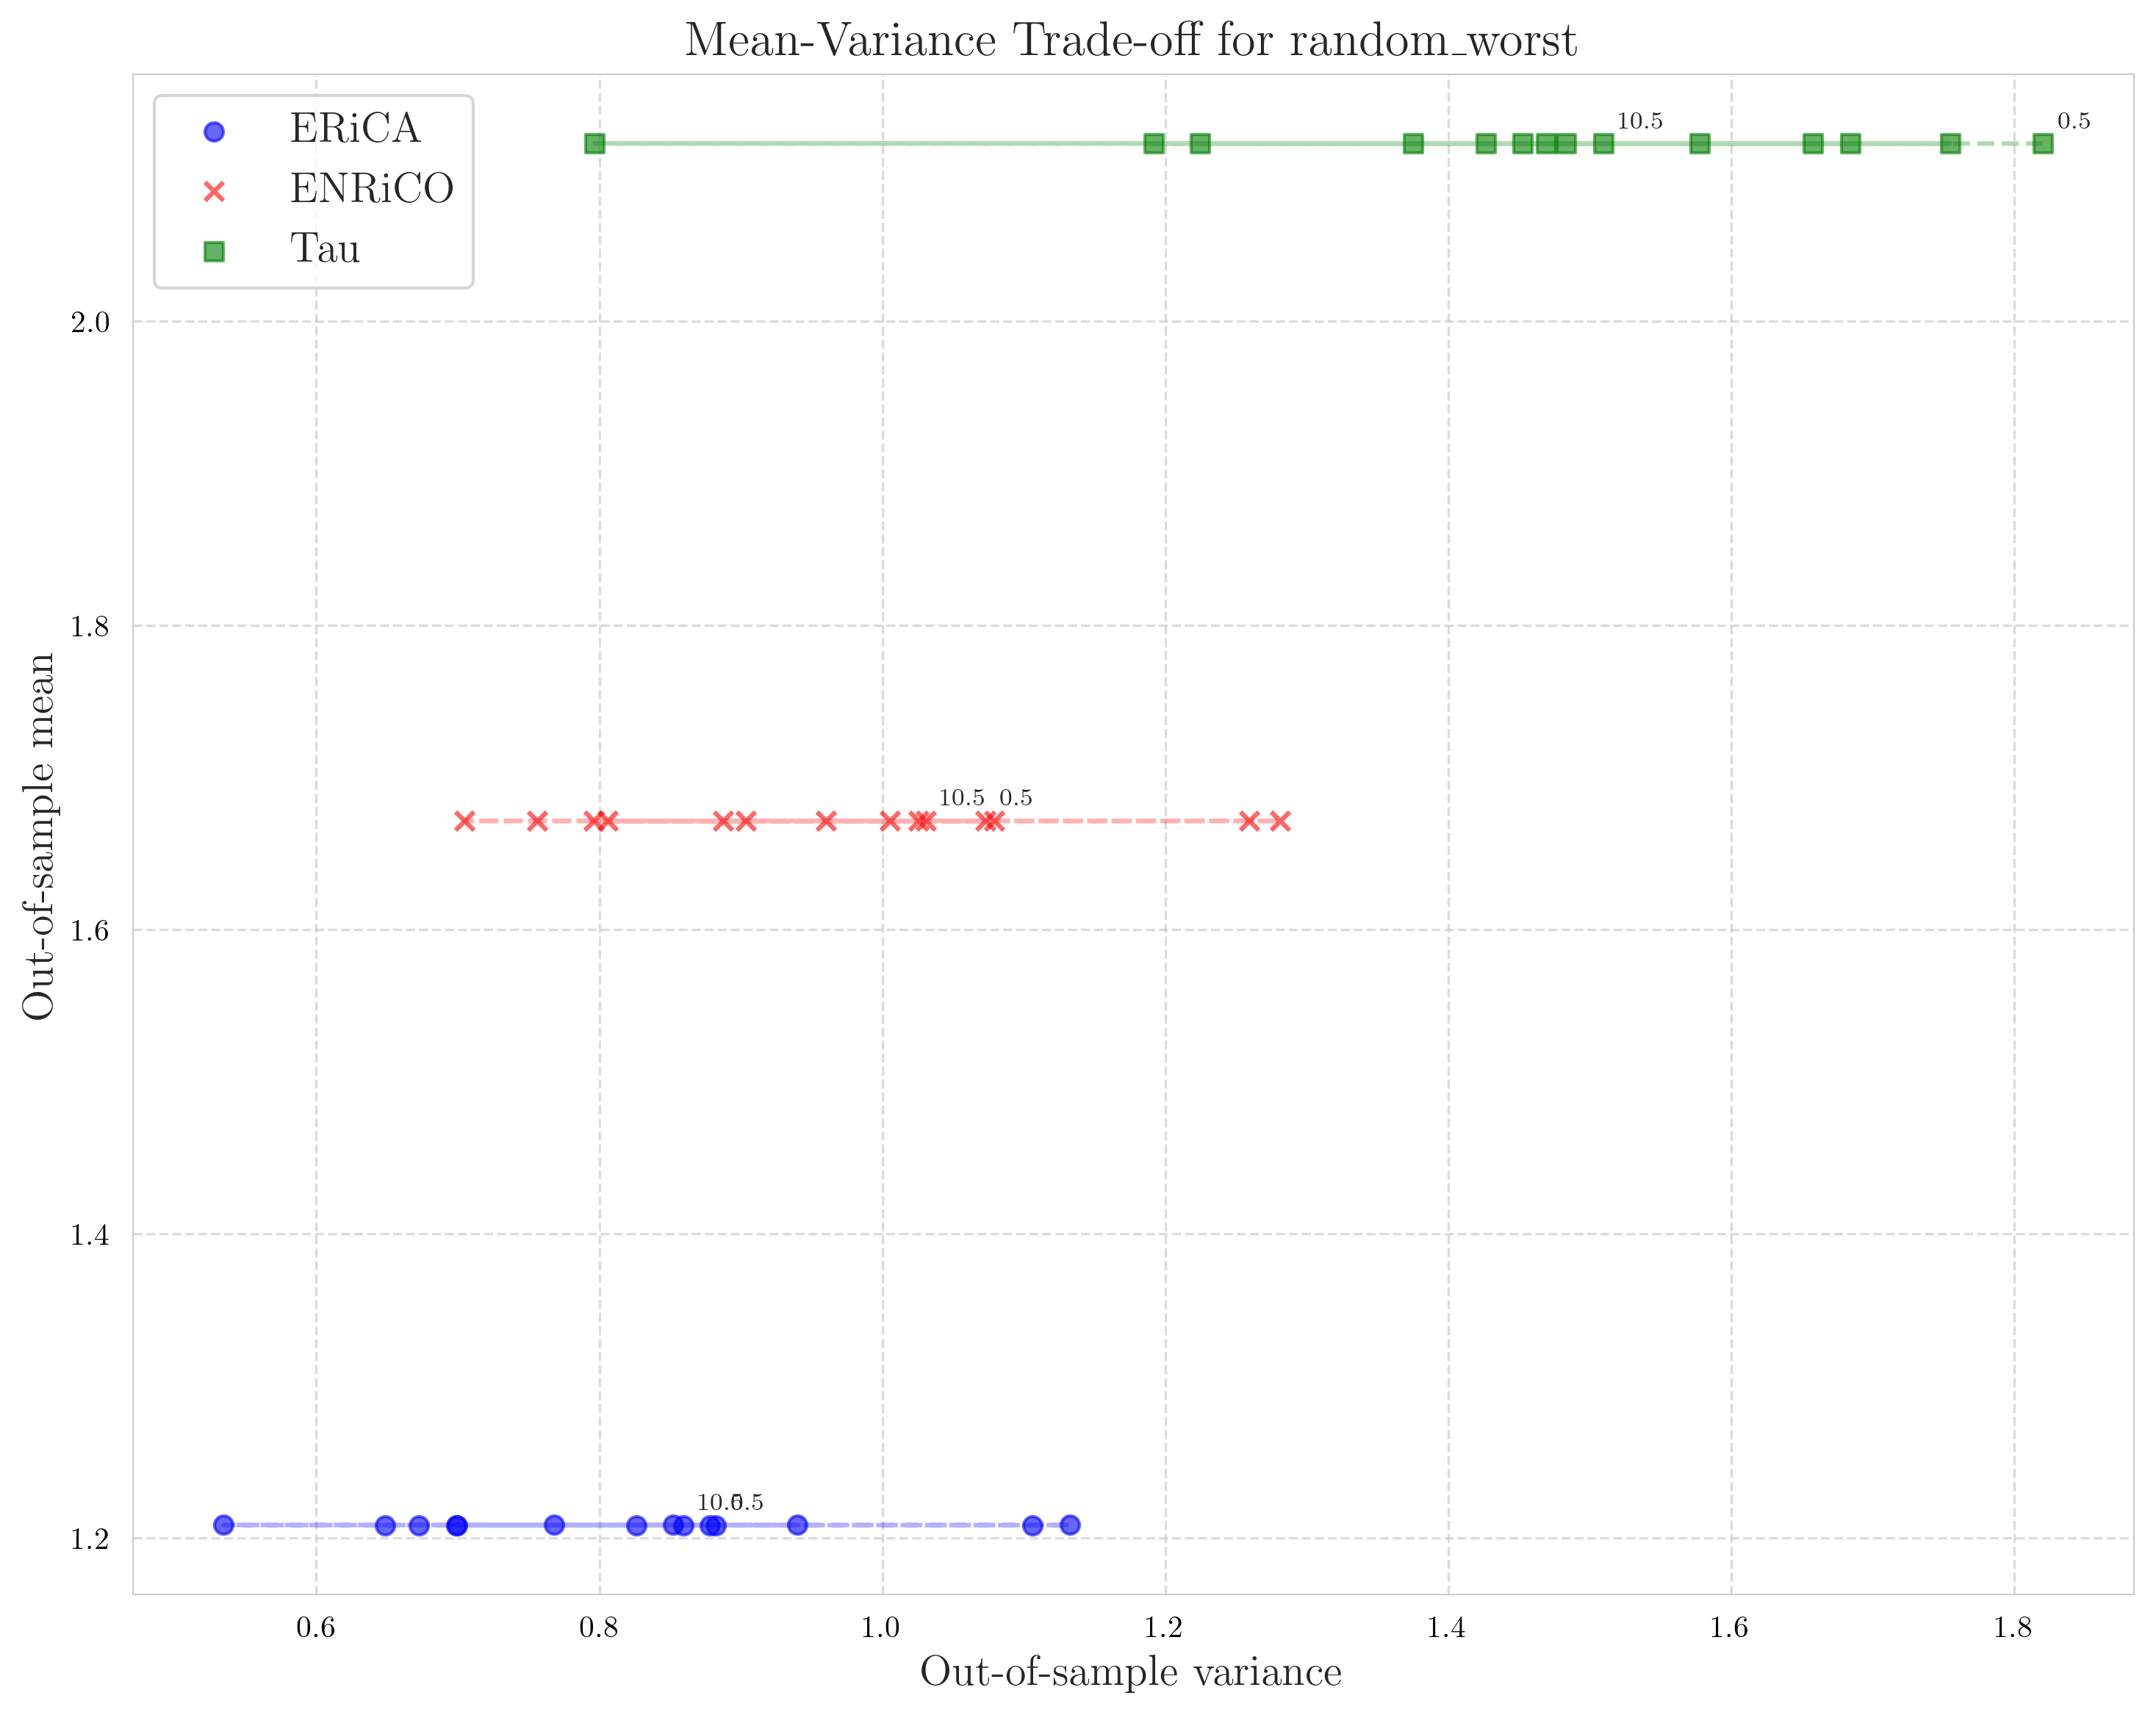

100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


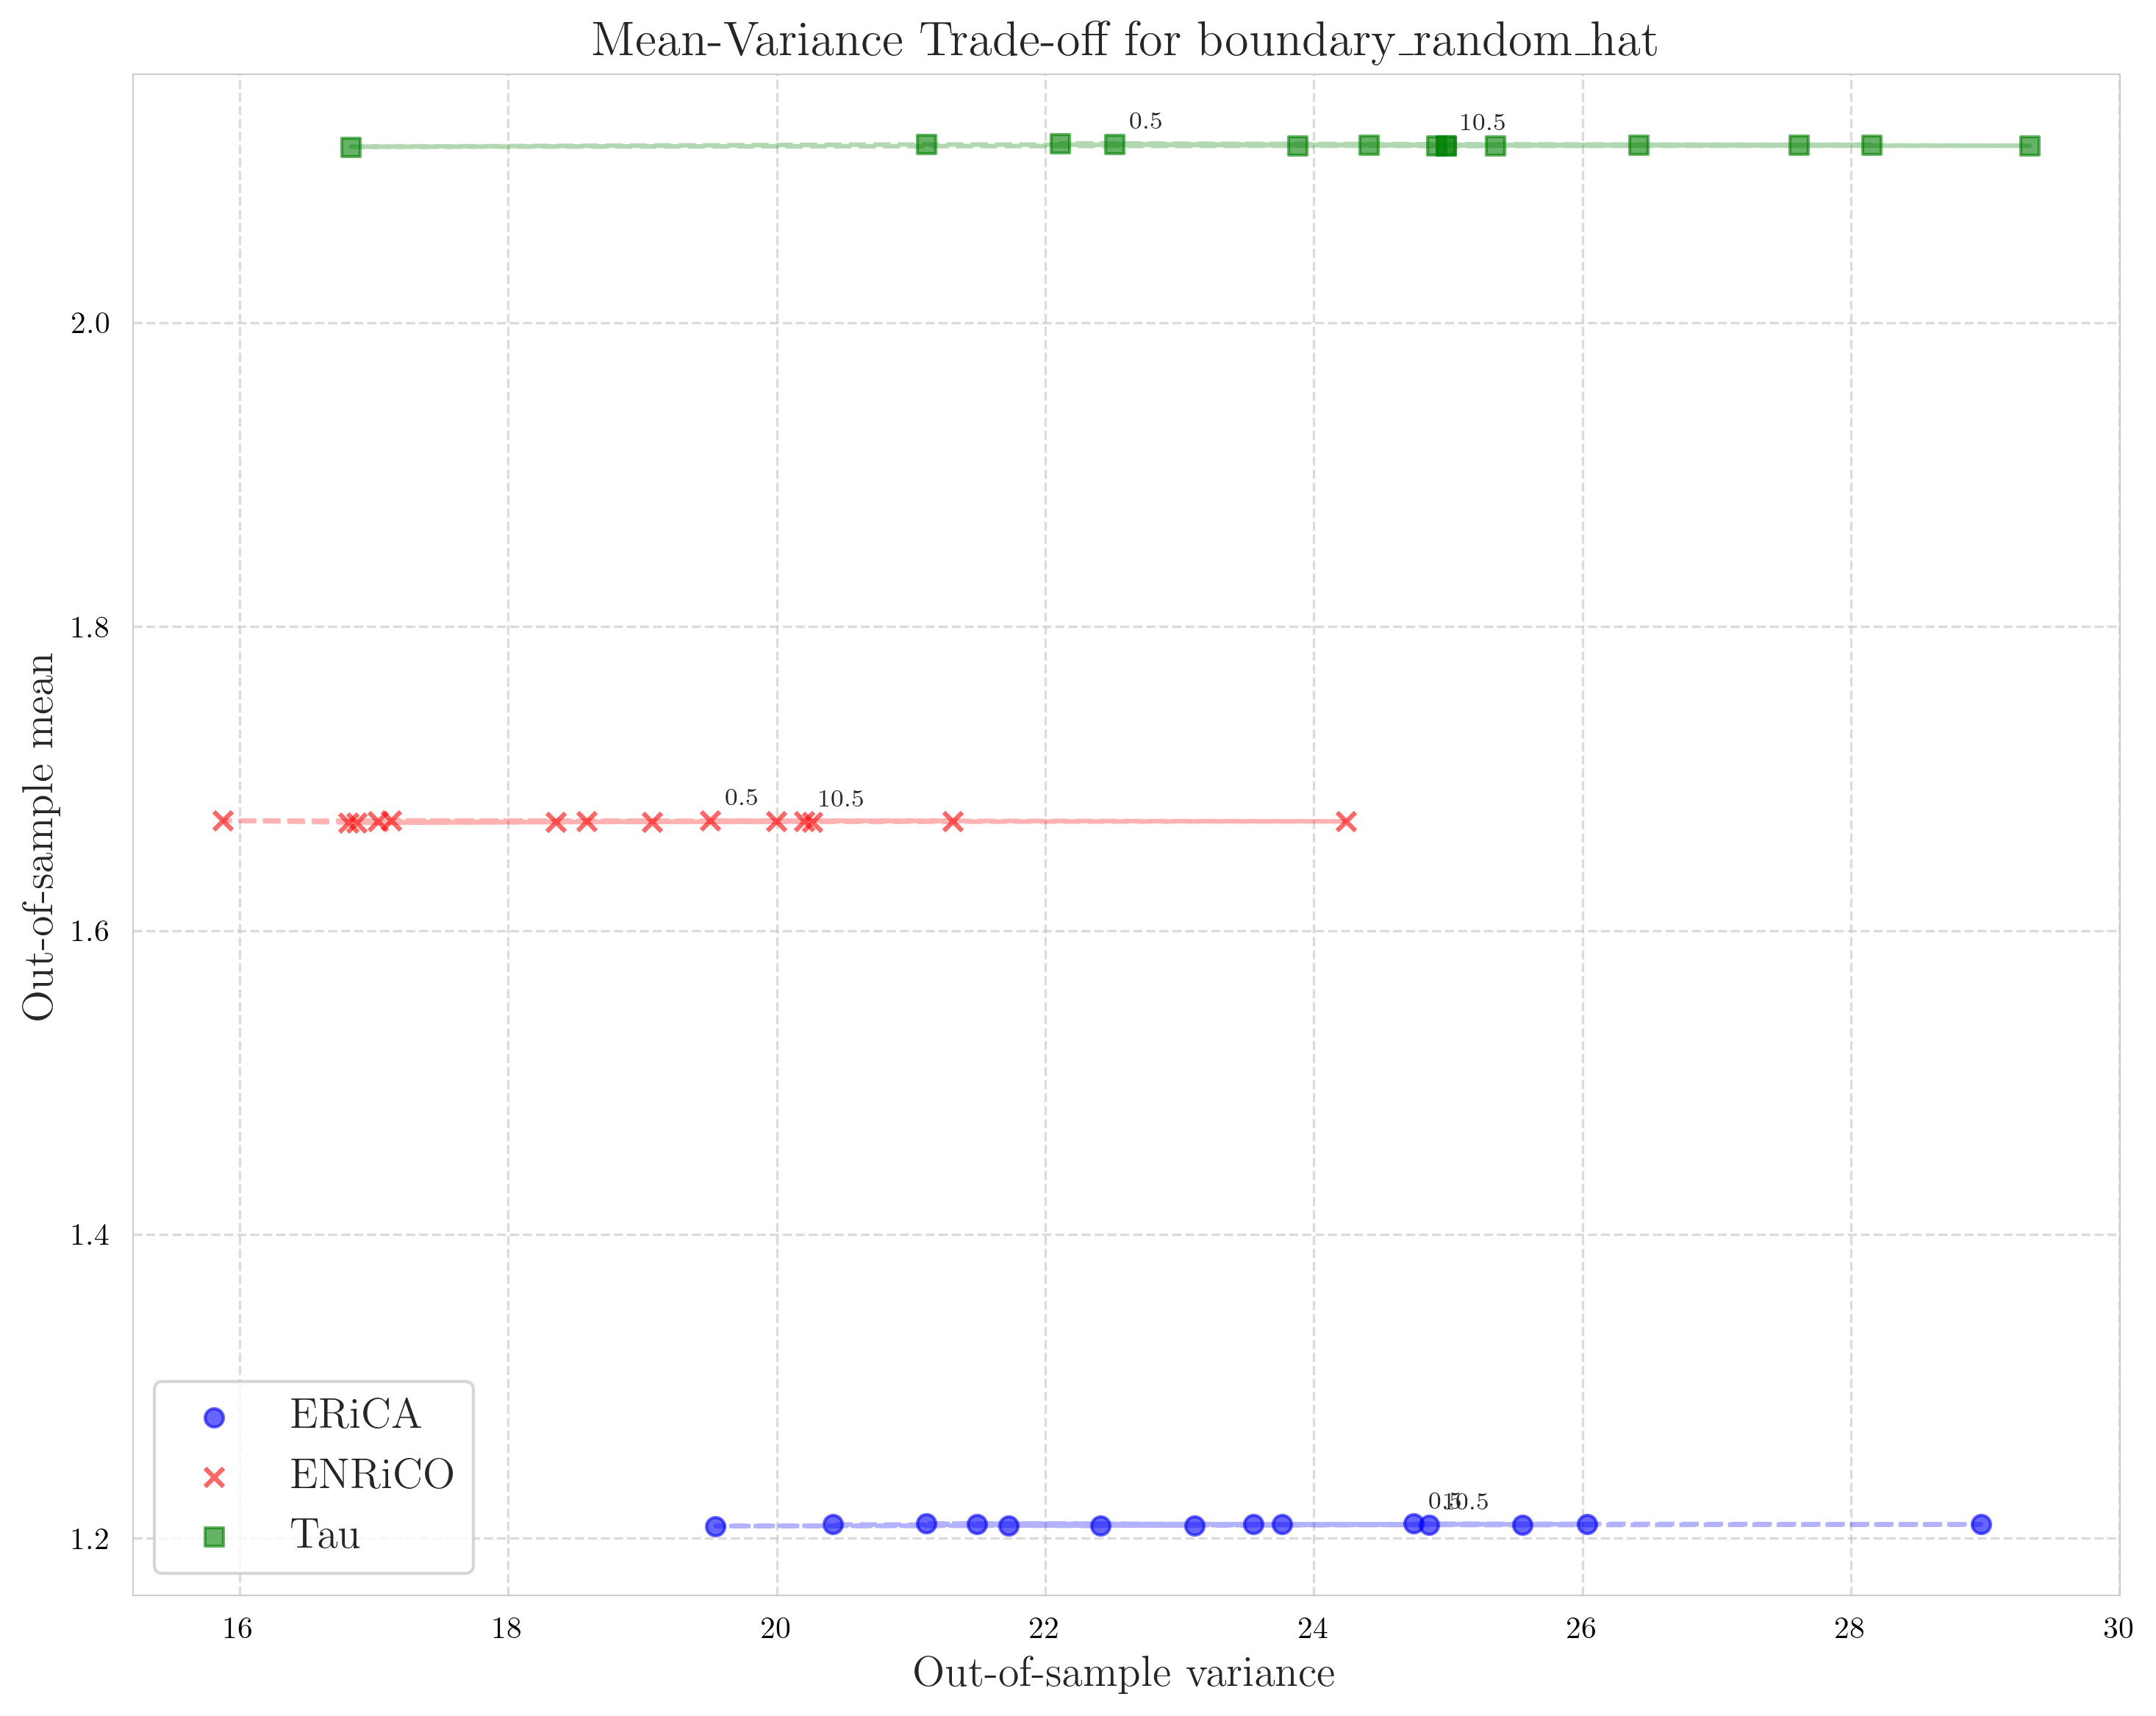

100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


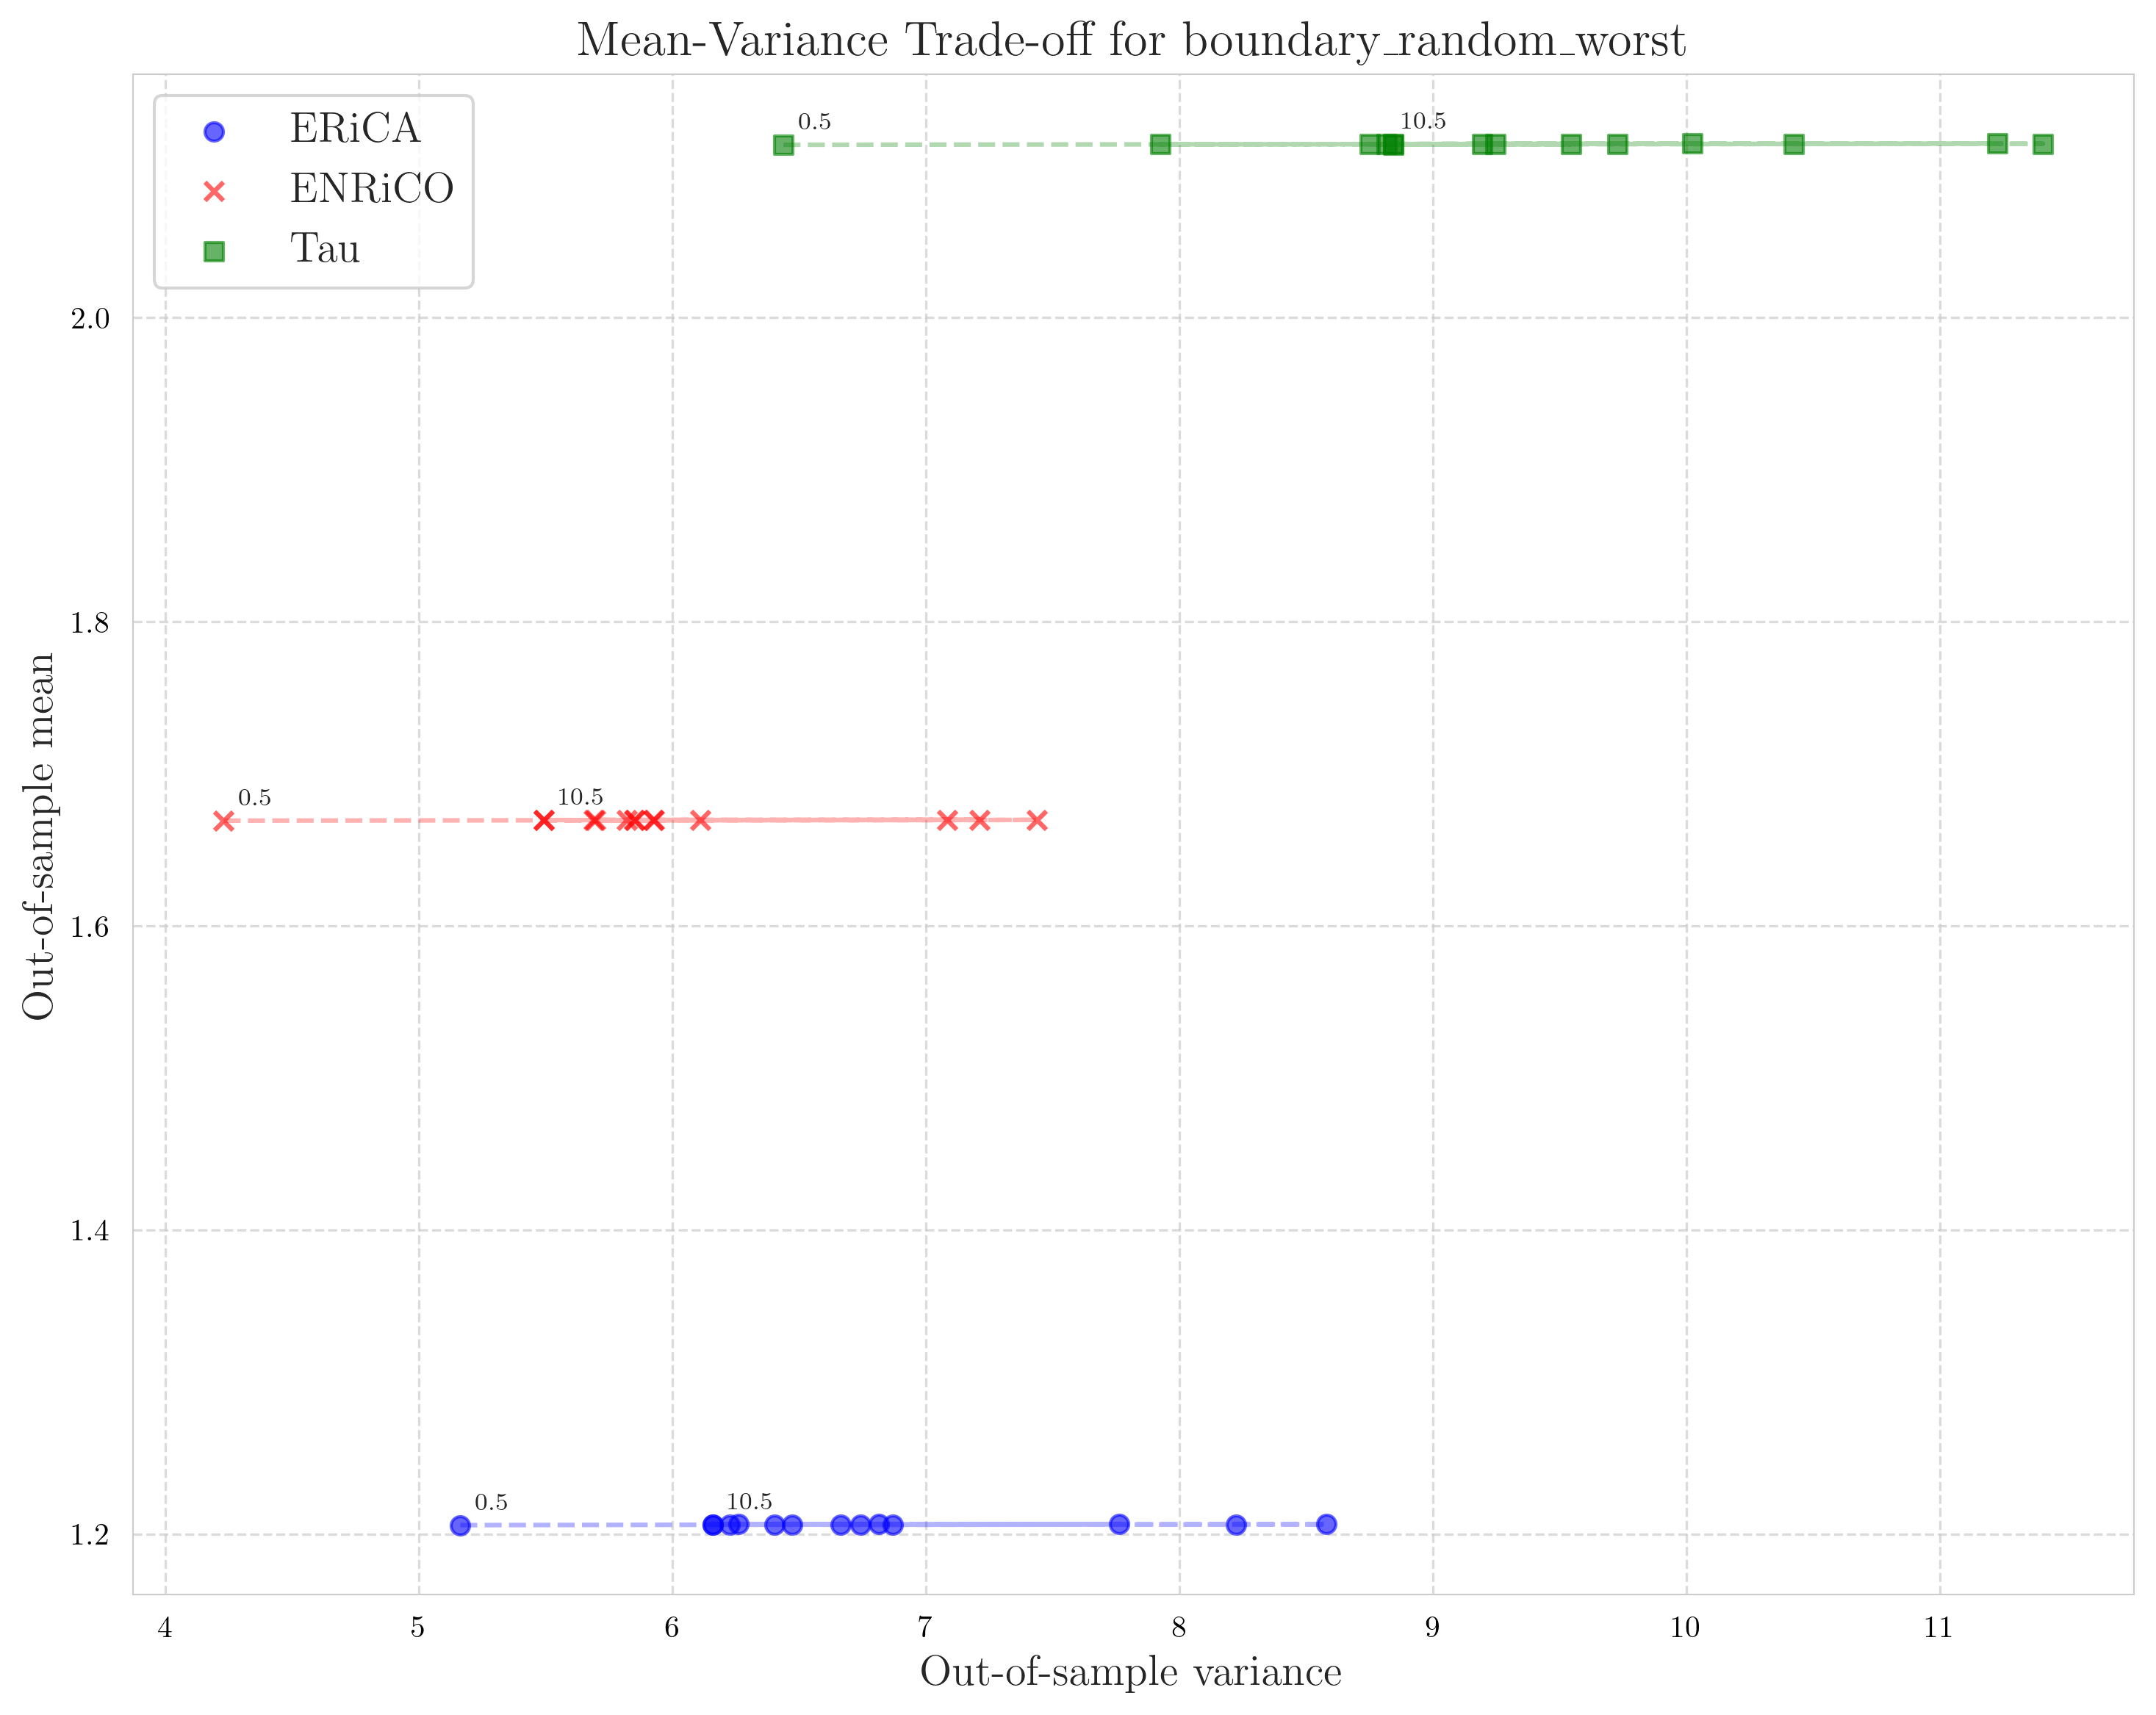

100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


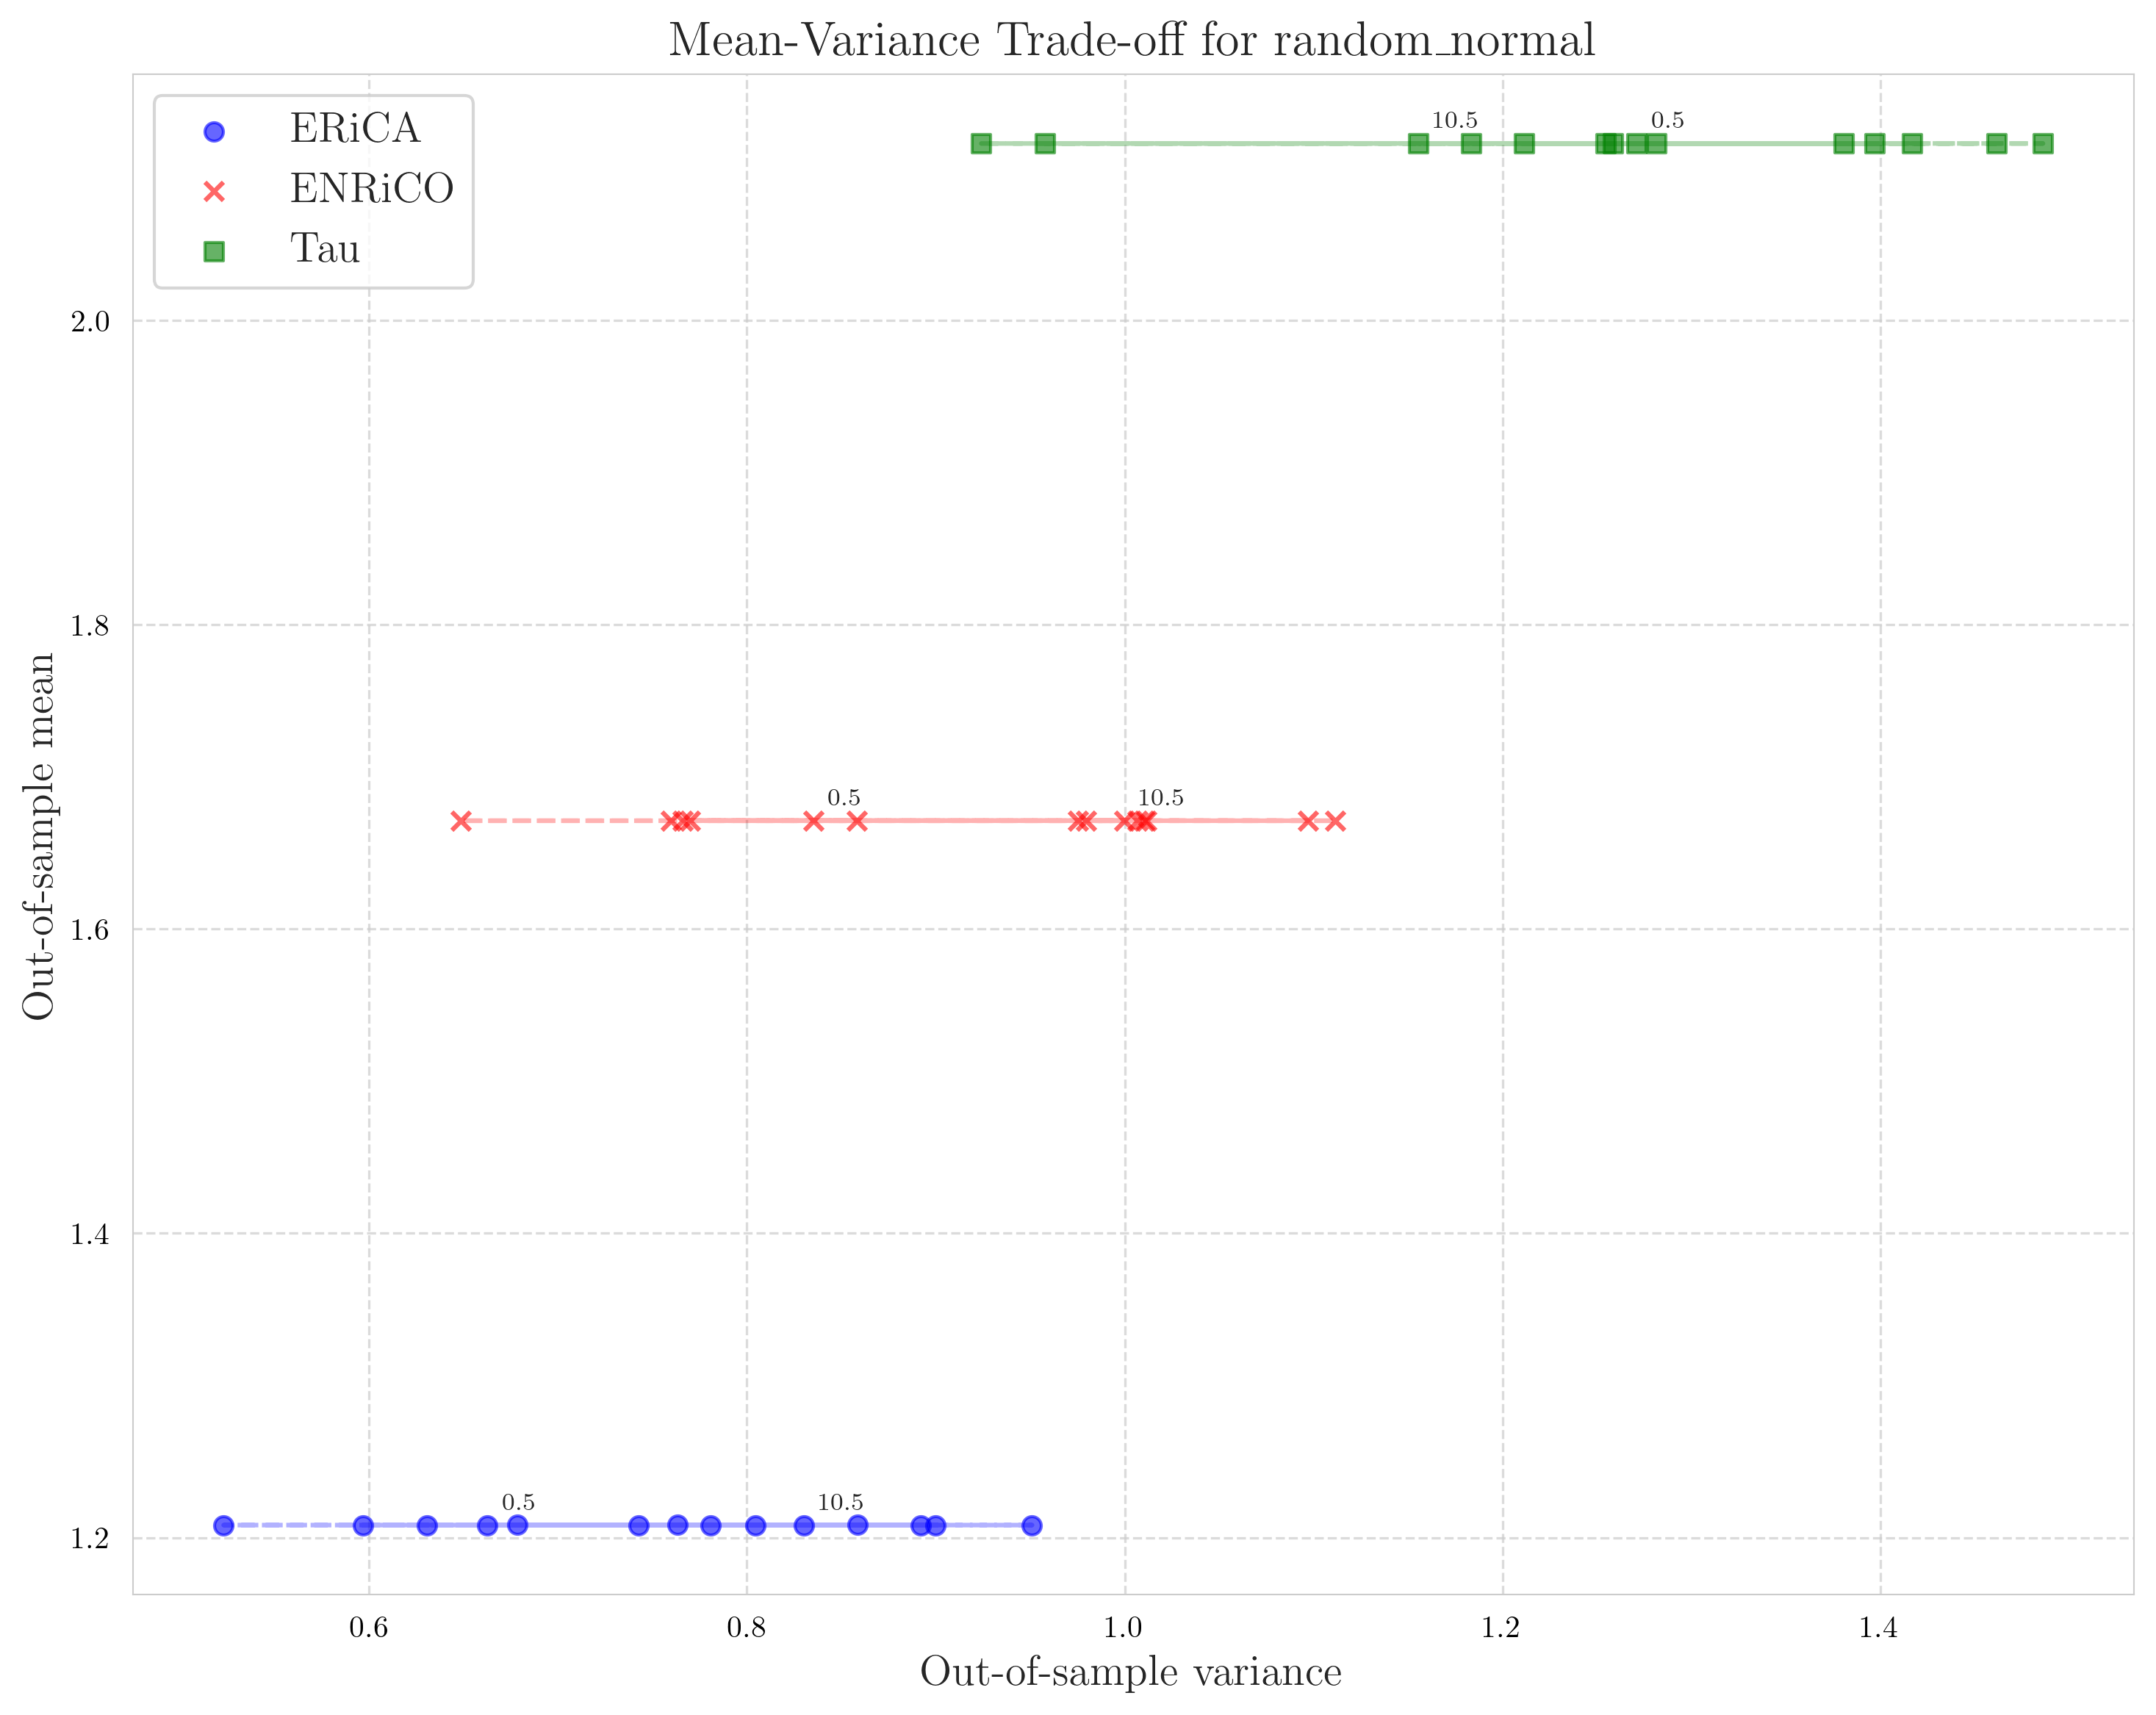

In [115]:
for pert in pert_types:
    pert_typeL = pert
    pert_typeH = pert
    radius_values = np.arange(.5, 14.5, 1).tolist()

    # Initialize dictionary to store results
    method_results = {
        'ERiCA': {'T': T_erica, 'means': [], 'variances': [], 'radius_labels': []},
        'ENRiCO': {'T': T_enrico, 'means': [], 'variances': [], 'radius_labels': []},
        'Tau': {'T': Tau, 'means': [], 'variances': [], 'radius_labels': []}
    }
    #method_results = {'ERiCA': {'T': T_erica, 'means': [], 'variances': [], 'radius_labels': []}}
    # Test each radius
    for radius in tqdm(radius_values):
        current_errors = {method: [] for method in method_results.keys()}
        
        for _ in range(num_iter):
            # Generate noise once per iteration
            pert_L = generate_pertubation(pert_typeL, 'L', experiment, rad=radius)
            pert_H = generate_pertubation(pert_typeH, 'H', experiment, rad=radius)

            for method_name, method_info in method_results.items():
                total = 0
                for iota in test_data.keys():
        
                    base, abst = test_data[iota]

                    if add_pertL:
                        base = base + pert_L 
                    if add_pertH:
                        abst = abst + pert_H 
                        
                    base_norm = base / np.linalg.norm(base, 'fro')
                    abst_norm = abst / np.linalg.norm(abst, 'fro')

                    tau_base = base @ method_info['T'].T
                    dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                    total   += dist
            
                iter_avg = total / len(Ill)
                current_errors[method_name].append(iter_avg)
        
        # Store mean and variance for all methods
        for method_name in method_results:
            errors = current_errors[method_name]
            method_results[method_name]['means'].append(np.mean(errors)/10000)
            method_results[method_name]['variances'].append(np.std(errors))
            method_results[method_name]['radius_labels'].append(radius)

    # Create plot
    plt.figure(figsize=(10, 8))

    colors = {'ERiCA': 'blue', 'ENRiCO': 'red', 'Tau': 'green'}
    markers = {'ERiCA': 'o', 'ENRiCO': 'x', 'Tau': 's'}
    
    for method_name, method_info in method_results.items():
        means = method_info['means']
        variances = method_info['variances']
        radius_labels = method_info['radius_labels']
        
        # Create scatter plot with lines connecting points
        plt.plot(variances, means, 
                color=colors[method_name],
                linestyle='--',
                alpha=0.3)
        
        plt.scatter(variances, means,
                   color=colors[method_name],
                   marker=markers[method_name],
                   label=method_name,
                   alpha=0.6)
        
        # Add radius labels to selected points (e.g., every 20th point)
        for i in range(0, len(radius_labels), 10):
            plt.annotate(f'{radius_labels[i]:.1f}',
                        (variances[i], means[i]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8)

    plt.xlabel('Out-of-sample variance')
    plt.ylabel('Out-of-sample mean')
    plt.title(f'Mean-Variance Trade-off for {pert}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [116]:
params_erica['']

{'L': {'pert_U': array([[-1.4362063 ,  0.36790392, -0.6661582 ],
         [ 0.45409942, -0.45787114,  1.1144302 ],
         [ 1.1614845 ,  0.68430686, -1.0327164 ],
         ...,
         [-0.07328907,  0.15869261, -0.7182101 ],
         [ 1.8846036 , -0.52673316,  1.7400004 ],
         [ 0.73480475, -0.0660063 ,  1.0404745 ]], dtype=float32),
  'radius_worst': 1.8759864800748938,
  'pert_hat': tensor([[ 1.0514, -1.9269,  0.2506],
          [ 1.2814, -0.3493,  0.5575],
          [ 1.1150, -1.9952,  1.6094],
          ...,
          [ 1.4841, -2.8457,  0.5806],
          [ 1.0538, -2.5250,  0.3807],
          [ 0.6024, -0.8448,  0.5519]]),
  'radius': 3},
 'H': {'pert_U': array([[-0.9424482 , -1.38652   ],
         [ 0.38262   ,  1.323944  ],
         [ 1.7266499 ,  0.38255212],
         ...,
         [ 0.46256152,  0.3340331 ],
         [ 1.0918287 ,  0.2849734 ],
         [ 0.10302369,  0.5857212 ]], dtype=float32),
  'radius_worst': 1.463439334237798,
  'pert_hat': tensor([[ 2.7576, 

In [117]:
def compute_empirical_worst_case_distance(params_worst):
    pert_worst = params_worst['pert_U']
    N          = pert_worst.shape[0]

    return (1/np.sqrt(N)) * np.linalg.norm(pert_worst, 'fro') #torch.norm(pert_worst, p='fro') maybe torch different output

In [28]:
pert_typeL = 'boundary_hat'
pert_typeH = 'boundary_hat'
tau = T_erica

for radius in [2, 3, 8, 12]:
    print(f"Radius: {radius}")
    
    
    params_erica, T_erica = oput.run_empirical_erica_optimization(**{**opt_params_erica, 'epsilon': radius, 'delta': radius})
   
    pwL = compute_empirical_worst_case_distance(params_erica['L'])
    pwH = compute_empirical_worst_case_distance(params_erica['H'])

    print(f"For L (epsilon): frobenius norm: {pwL}, radius_squared: {radius**2}, constraint satisfied: {pwL <= radius**2}")
    print(f"For H (delta): frobenius: {pwH}, radius_squared: {radius**2}, constraint satisfied: {pwH <= radius**2}")

    # Define the grid of radii to test
    radius_values = np.arange(.005, 1, .0015).tolist()  
    # Initialize arrays to store results
    error_values = np.zeros(len(radius_values))
    std_values   = np.zeros(len(radius_values))

    # Test each radius (using same value for L and H)
    for i, radius in enumerate(tqdm(radius_values)):
        abstraction_errors = []

        for _ in range(num_iter):
            pert_L = generate_pertubation(pert_typeL, 'L', experiment, rad=radius)
            pert_H = generate_pertubation(pert_typeH, 'H', experiment, rad=radius)

            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]

                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')

                tau_base = base @ T_erica.T
                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                total += dist
                            
            iter_avg = total / len(Ill)
            abstraction_errors.append(iter_avg)
        
        # Store mean and std for this radius
        error_values[i] = np.mean(abstraction_errors)
        std_values[i] = np.std(abstraction_errors)
        
        # Create 2D plot
    plt.figure(figsize=(12, 8))
    plt.plot(radius_values, error_values, 'o')
    #plt.plot([x**2 for x in radius_values], error_values, 'o')

    plt.xlabel(r'Radius ($\varepsilon=\delta$)')  # Using LaTeX notation
    plt.ylabel('Abstraction Error')
    plt.title('Abstraction Error vs Radius Value')
    plt.tight_layout()
    plt.show()

    # Print best radius
    best_idx = np.argmin(error_values)
    print("\nBest radius value:")
    print(f"Radius (ε=δ): {radius_values[best_idx]}")
    print(f"Mean error: {error_values[best_idx]:.4f} ± {std_values[best_idx]*1.96:.4f}")
    print( )

Radius: 2


100%|██████████| 500/500 [01:21<00:00,  6.14it/s]


NameError: name 'compute_empirical_worst_case_distance' is not defined